## Descriptions:
Reads isocontours from a number of timesteps and seperates the data according to the algebraic value of curvature into groups. For example using 3 groups we can have Group 0 with curvature below -0.01, Group 1 with -0.01< curvature < 0.01 and Group 2 with curvature > 0.01. Then it runs backward feature selection both globally(All of the groups together) as well as for each group individually and outputs the N best features, where the number N is user defined.

In [1]:
from __future__ import annotations
from pathlib import Path
import os
os.chdir("../../..")
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from flamekit.io_fronts import Case, load_fronts


### Read config file and define helper functions

In [2]:

PROJECT_ROOT = Path.cwd().resolve()
CONFIG_PATH = PROJECT_ROOT / "notebooks" / "case_studies/Feature_selection_backward" / "Feature_selection_backward.yaml"
CFG = yaml.safe_load(CONFIG_PATH.read_text(encoding="utf-8"))

BASE_DIR = PROJECT_ROOT / Path(CFG["BASE_DIR"])
PHI = float(CFG["PHI"])
LAT_SIZE = str(CFG["LAT_SIZE"])
POST = bool(CFG["POST"])

TIME_STEPS = list(CFG["TIME_STEPS"])
ISOLEVEL = float(CFG["ISOLEVEL"])
TARGET_VAR = str(CFG["TARGET_VAR"])

CLUSTER_ON_SPATIAL = bool(CFG["CLUSTER_ON_SPATIAL"])

CLUSTER_FEATURES_INCLUDE = set(CFG["CLUSTER_FEATURES_INCLUDE"])

MODEL_FEATURES_INCLUDE = set(CFG["MODEL_FEATURES_INCLUDE"])

FEATURES_EXCLUDE = set(CFG.get("FEATURES_EXCLUDE", []))

CURVATURE_COLUMN = str(CFG["CURVATURE_COLUMN"])
CURVATURE_BOUNDS = tuple(CFG["CURVATURE_BOUNDS"])
N_CLUSTERS = len(CURVATURE_BOUNDS) + 1

MIN_CLUSTER_SAMPLES = int(CFG["MIN_CLUSTER_SAMPLES"])
RANDOM_STATE = int(CFG["RANDOM_STATE"])
TEST_SIZE = float(CFG["TEST_SIZE"])

# Backward selection
BACKWARD_N_FEATURES_GLOBAL = int(CFG["BACKWARD_N_FEATURES_GLOBAL"])
BACKWARD_N_FEATURES_CLUSTER = int(CFG["BACKWARD_N_FEATURES_CLUSTER"])
SFS_SCORING = str(CFG["SFS_SCORING"])
SFS_CV_SPLITS = int(CFG["SFS_CV_SPLITS"])

MODEL_PARAMS = dict(CFG["MODEL_PARAMS"])
MODEL_PARAMS.setdefault("random_state", RANDOM_STATE)

# =========================
# PLOT STYLE (model_verification reference)
# =========================

PLOT_FONT_FAMILY = "Courier New"
PLOT_FONT_SIZE = 20
FIG_SIZE = (6.8, 6.2)

ISO_FIG_SIZE = (7.6, 7.6)
SCATTER_S_ISO = 10
ALPHA_ISO = 0.6


def apply_plot_style() -> None:
    plt.rcParams.update({
        "font.family": PLOT_FONT_FAMILY,
        "font.size": PLOT_FONT_SIZE,
        "axes.titlesize": PLOT_FONT_SIZE,
        "axes.labelsize": PLOT_FONT_SIZE,
        "xtick.labelsize": PLOT_FONT_SIZE,
        "ytick.labelsize": PLOT_FONT_SIZE,
        "legend.fontsize": PLOT_FONT_SIZE,
        "figure.titlesize": PLOT_FONT_SIZE,
        "axes.linewidth": 1.2,
    })


apply_plot_style()

COLOR_DATA = "#77b5b6"
COLOR_DATA_EDGE = "#378d94"
COLOR_PRED = "#9671bd"
COLOR_PRED_EDGE = "#6a408d"
COLOR_NEUTRAL = "#7e7e7e"
COLOR_LINE = "#8a8a8a"

LABEL_SD = r"$\tilde{S}_d^*$"

LINE_WIDTH = 2.2
PRED_SCATTER_S = 18
PRED_ALPHA = 0.6
LEGEND_KWARGS = dict(
    frameon=False,
    fontsize=PLOT_FONT_SIZE - 2,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.10),
    ncol=2,
    borderaxespad=0.0,
)


def style_axes(ax, *, equal: bool = False) -> None:
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle="-", linewidth=0.75, alpha=0.25)
    ax.grid(True, which="minor", linestyle="-", linewidth=0.25, alpha=0.15)
    ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)
    ax.tick_params(axis="both", which="major", length=6, width=1.0)
    ax.tick_params(axis="both", which="minor", length=3, width=0.8)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    if equal:
        ax.set_aspect("equal", adjustable="box")


def _cluster_cmap_and_norm(n_clusters: int):
    from matplotlib.colors import ListedColormap, BoundaryNorm

    base_colors = [
        COLOR_DATA,
        COLOR_NEUTRAL,
        COLOR_PRED,
        COLOR_DATA_EDGE,
        COLOR_PRED_EDGE,
        COLOR_LINE,
    ]

    if n_clusters <= len(base_colors):
        colors = base_colors[:n_clusters]
    else:
        base = plt.get_cmap("tab20")
        colors = [base(i) for i in range(n_clusters)]

    cmap = ListedColormap(colors)
    boundaries = np.arange(-0.5, n_clusters + 0.5, 1.0)
    norm = BoundaryNorm(boundaries, ncolors=n_clusters)
    return cmap, norm, boundaries


def plot_isocontour_scatter(
    df: pd.DataFrame,
    save_stem: str | None = None,
) -> None:
    if "x" not in df.columns or "y" not in df.columns:
        print("[WARN] Missing x/y for isocontour scatter; skipping.")
        return
    fig, ax = plt.subplots(figsize=ISO_FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
    if "cluster" in df.columns:
        cmap, norm, boundaries = _cluster_cmap_and_norm(N_CLUSTERS)
        sc = ax.scatter(
            df["y"],
            df["x"],
            c=df["cluster"].astype(int),
            s=SCATTER_S_ISO,
            alpha=ALPHA_ISO,
            cmap=cmap,
            norm=norm,
            edgecolors="none",
            zorder=3,
        )
        cbar = fig.colorbar(
            sc,
            ax=ax,
            fraction=0.046,
            pad=0.03,
            ticks=np.arange(N_CLUSTERS),
            boundaries=boundaries,
            spacing="proportional",
        )
        cbar.set_label("Cluster ID")
        cbar.ax.set_yticklabels([str(i) for i in range(N_CLUSTERS)])
    else:
        ax.scatter(
            df["y"],
            df["x"],
            s=SCATTER_S_ISO,
            alpha=ALPHA_ISO,
            color=COLOR_DATA,
            edgecolors=COLOR_DATA_EDGE,
            linewidths=0.6,
            zorder=3,
        )
    ax.set_xlabel("y")
    ax.set_ylabel("x")
    style_axes(ax, equal=True)
    if save_stem is not None:
        save_png(save_stem)
    plt.show()
    plt.close(fig)





# =========================
# PLOT SAVING (folder naming convention)
# =========================

OUTPUT_BASE_DIR = PROJECT_ROOT / Path(CFG["OUTPUT_BASE_DIR"])

def _time_steps_tag(time_steps: list[int]) -> str:
    if not time_steps:
        return "t_none"
    if len(time_steps) == 1:
        return f"t_{time_steps[0]}"
    t_min = min(time_steps)
    t_max = max(time_steps)
    return f"t_{t_min}_to_{t_max}"

RUN_DIR = OUTPUT_BASE_DIR / f"lat_{LAT_SIZE}" / _time_steps_tag(TIME_STEPS)
TS_TAG = "_".join(map(str, TIME_STEPS))
SAVE_DIR = RUN_DIR / f"h_{LAT_SIZE}_t_{TS_TAG}_iso_{ISOLEVEL}"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

FIG_DPI = int(CFG["FIG_DPI"])

def _safe_name(s: str) -> str:
    return "".join(ch if (ch.isalnum() or ch in "._-") else "_" for ch in s)

def save_png(stem: str, dpi: int = FIG_DPI):
    """Save current matplotlib figure as PNG/PDF to SAVE_DIR."""
    fname = SAVE_DIR / f"{_safe_name(stem)}.png"
    plt.gcf().savefig(fname, dpi=dpi, bbox_inches="tight", facecolor="white")
    plt.gcf().savefig(fname.with_suffix(".pdf"), bbox_inches="tight")

def save_then_show(stem: str, dpi: int = FIG_DPI):
    save_png(stem, dpi=dpi)
    plt.show()

SAVE_PRED_PLOTS = True


def plot_pred_vs_true(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    title: Optional[str] = None,
    save_stem: Optional[str] = None,
) -> None:
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
    ax.scatter(
        y_true,
        y_pred,
        s=PRED_SCATTER_S,
        alpha=PRED_ALPHA,
        color=COLOR_DATA,
        edgecolors=COLOR_DATA_EDGE,
        linewidths=0.5,
        label="Data",
    )
    lim_min = float(min(y_true.min(), y_pred.min()))
    lim_max = float(max(y_true.max(), y_pred.max()))
    ax.plot(
        [lim_min, lim_max],
        [lim_min, lim_max],
        linestyle="--",
        color=COLOR_LINE,
        linewidth=LINE_WIDTH,
        label="1:1",
    )
    ax.set_xlabel(f"{LABEL_SD} (true)")
    ax.set_ylabel(f"{LABEL_SD} (pred)")
    ax.legend(**LEGEND_KWARGS)
    style_axes(ax, equal=True)
    if SAVE_PRED_PLOTS and save_stem:
        save_png(save_stem, dpi=FIG_DPI)
    plt.show()
    plt.close(fig)


print(f"[INFO] Saving outputs to: {SAVE_DIR}")


# =========================
# Utilities
# =========================

def _numeric_cols(df: pd.DataFrame) -> List[str]:
    return [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]

def resolve_features(
    df: pd.DataFrame,
    include: Optional[List[str] | set[str]],
    exclude: set[str],
) -> List[str]:
    num = set(_numeric_cols(df))
    feats = num if include is None else set(include).intersection(num)
    feats = feats.difference(exclude)
    return sorted(feats)

def intersect_feature_space(feature_sets: List[set[str]]) -> List[str]:
    if not feature_sets:
        return []
    common = set.intersection(*feature_sets)
    return sorted(common)

def run_backward_selection(
    X: np.ndarray,
    y: np.ndarray,
    feature_names: List[str],
    n_features_to_select: int,
    random_state: int,
    scoring: str,
    cv_splits: int,
) -> List[str]:
    if X.shape[1] == 0:
        return []

    n_features_to_select = int(min(n_features_to_select, X.shape[1]))
    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    model = RandomForestRegressor(**MODEL_PARAMS)
    sfs = SequentialFeatureSelector(
        estimator=model,
        n_features_to_select=n_features_to_select,
        direction="backward",
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
    )

    sfs.fit(X, y)
    mask = sfs.get_support()
    return [f for f, keep in zip(feature_names, mask) if keep]


def evaluate_selected_model(
    X: np.ndarray,
    y: np.ndarray,
    test_size: float,
    random_state: int,
) -> Tuple[float, float, np.ndarray, np.ndarray]:
    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    model = RandomForestRegressor(**MODEL_PARAMS)
    model.fit(Xtr, ytr)

    ypred = model.predict(Xte)
    r2 = float(r2_score(yte, ypred))
    rmse = float(np.sqrt(mean_squared_error(yte, ypred)))
    return r2, rmse, yte, ypred


[INFO] Saving outputs to: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/report_figures/results/backward_selection/lat_100/t_198_to_202/h_100_t_198_199_200_201_202_iso_0.6


### Load data

In [3]:
dfs = []
cluster_feature_sets_per_t: List[set[str]] = []
model_feature_sets_per_t: List[set[str]] = []

cluster_include = set(CLUSTER_FEATURES_INCLUDE)
if CLUSTER_ON_SPATIAL:
    cluster_include = cluster_include.union({"x", "y", "z"})

model_include = set(MODEL_FEATURES_INCLUDE)

for ts in TIME_STEPS:
    CASE = Case(
        base_dir=BASE_DIR,
        phi=PHI,
        lat_size=LAT_SIZE,
        time_step=ts,
        post=POST,
    )

    fronts = load_fronts(CASE, [ISOLEVEL])
    if ISOLEVEL not in fronts:
        raise ValueError(f"ISOLEVEL {ISOLEVEL} not found for timestep {ts}")

    df_t = fronts[ISOLEVEL].copy()
    df_t["c_iso"] = float(ISOLEVEL)
    df_t["timestep"] = int(ts)

    if TARGET_VAR not in df_t.columns:
        raise ValueError(f"TARGET_VAR '{TARGET_VAR}' not found for timestep {ts}")

    cl_feats_t = set(resolve_features(df_t, cluster_include, FEATURES_EXCLUDE))
    ml_feats_t = set(resolve_features(df_t, model_include, FEATURES_EXCLUDE))

    cluster_feature_sets_per_t.append(cl_feats_t)
    model_feature_sets_per_t.append(ml_feats_t)

    dfs.append(df_t)

df_all = pd.concat(dfs, ignore_index=True)
print(f"Pooled rows total: n={len(df_all)} across timesteps={TIME_STEPS}")

cluster_features = intersect_feature_space(cluster_feature_sets_per_t)
model_features = intersect_feature_space(model_feature_sets_per_t)

if len(cluster_features) == 0:
    raise ValueError("No common numeric CLUSTER features across requested timesteps. Adjust CLUSTER_FEATURES_INCLUDE.")
if len(model_features) == 0:
    raise ValueError("No common numeric MODEL features across requested timesteps. Adjust MODEL_FEATURES_INCLUDE.")

print(f"\nCluster features (common across all timesteps): {cluster_features}")
print(f"Model features (common across all timesteps):   {model_features}")

required = sorted(set(cluster_features).union(model_features).union({TARGET_VAR, CURVATURE_COLUMN}))
dfc = df_all.dropna(subset=required).copy()
print(f"\nAfter dropna on required (cluster+model+target): n={len(dfc)}")

Pooled rows total: n=16507 across timesteps=[198, 199, 200, 201, 202]

Cluster features (common across all timesteps): ['curvature']
Model features (common across all timesteps):   ['curvature', 'dTdx', 'dTdy', 'dcurvdx', 'dcurvdy', 'du_ndx', 'du_ndy', 'du_tdx', 'du_tdy', 'normal_strain_rate', 'tangential_strain_rate', 'u_n', 'u_t', 'vorticity']

After dropna on required (cluster+model+target): n=16507


### Global backward selection


Global backward selection:
['curvature', 'dTdx', 'dTdy', 'du_ndy']


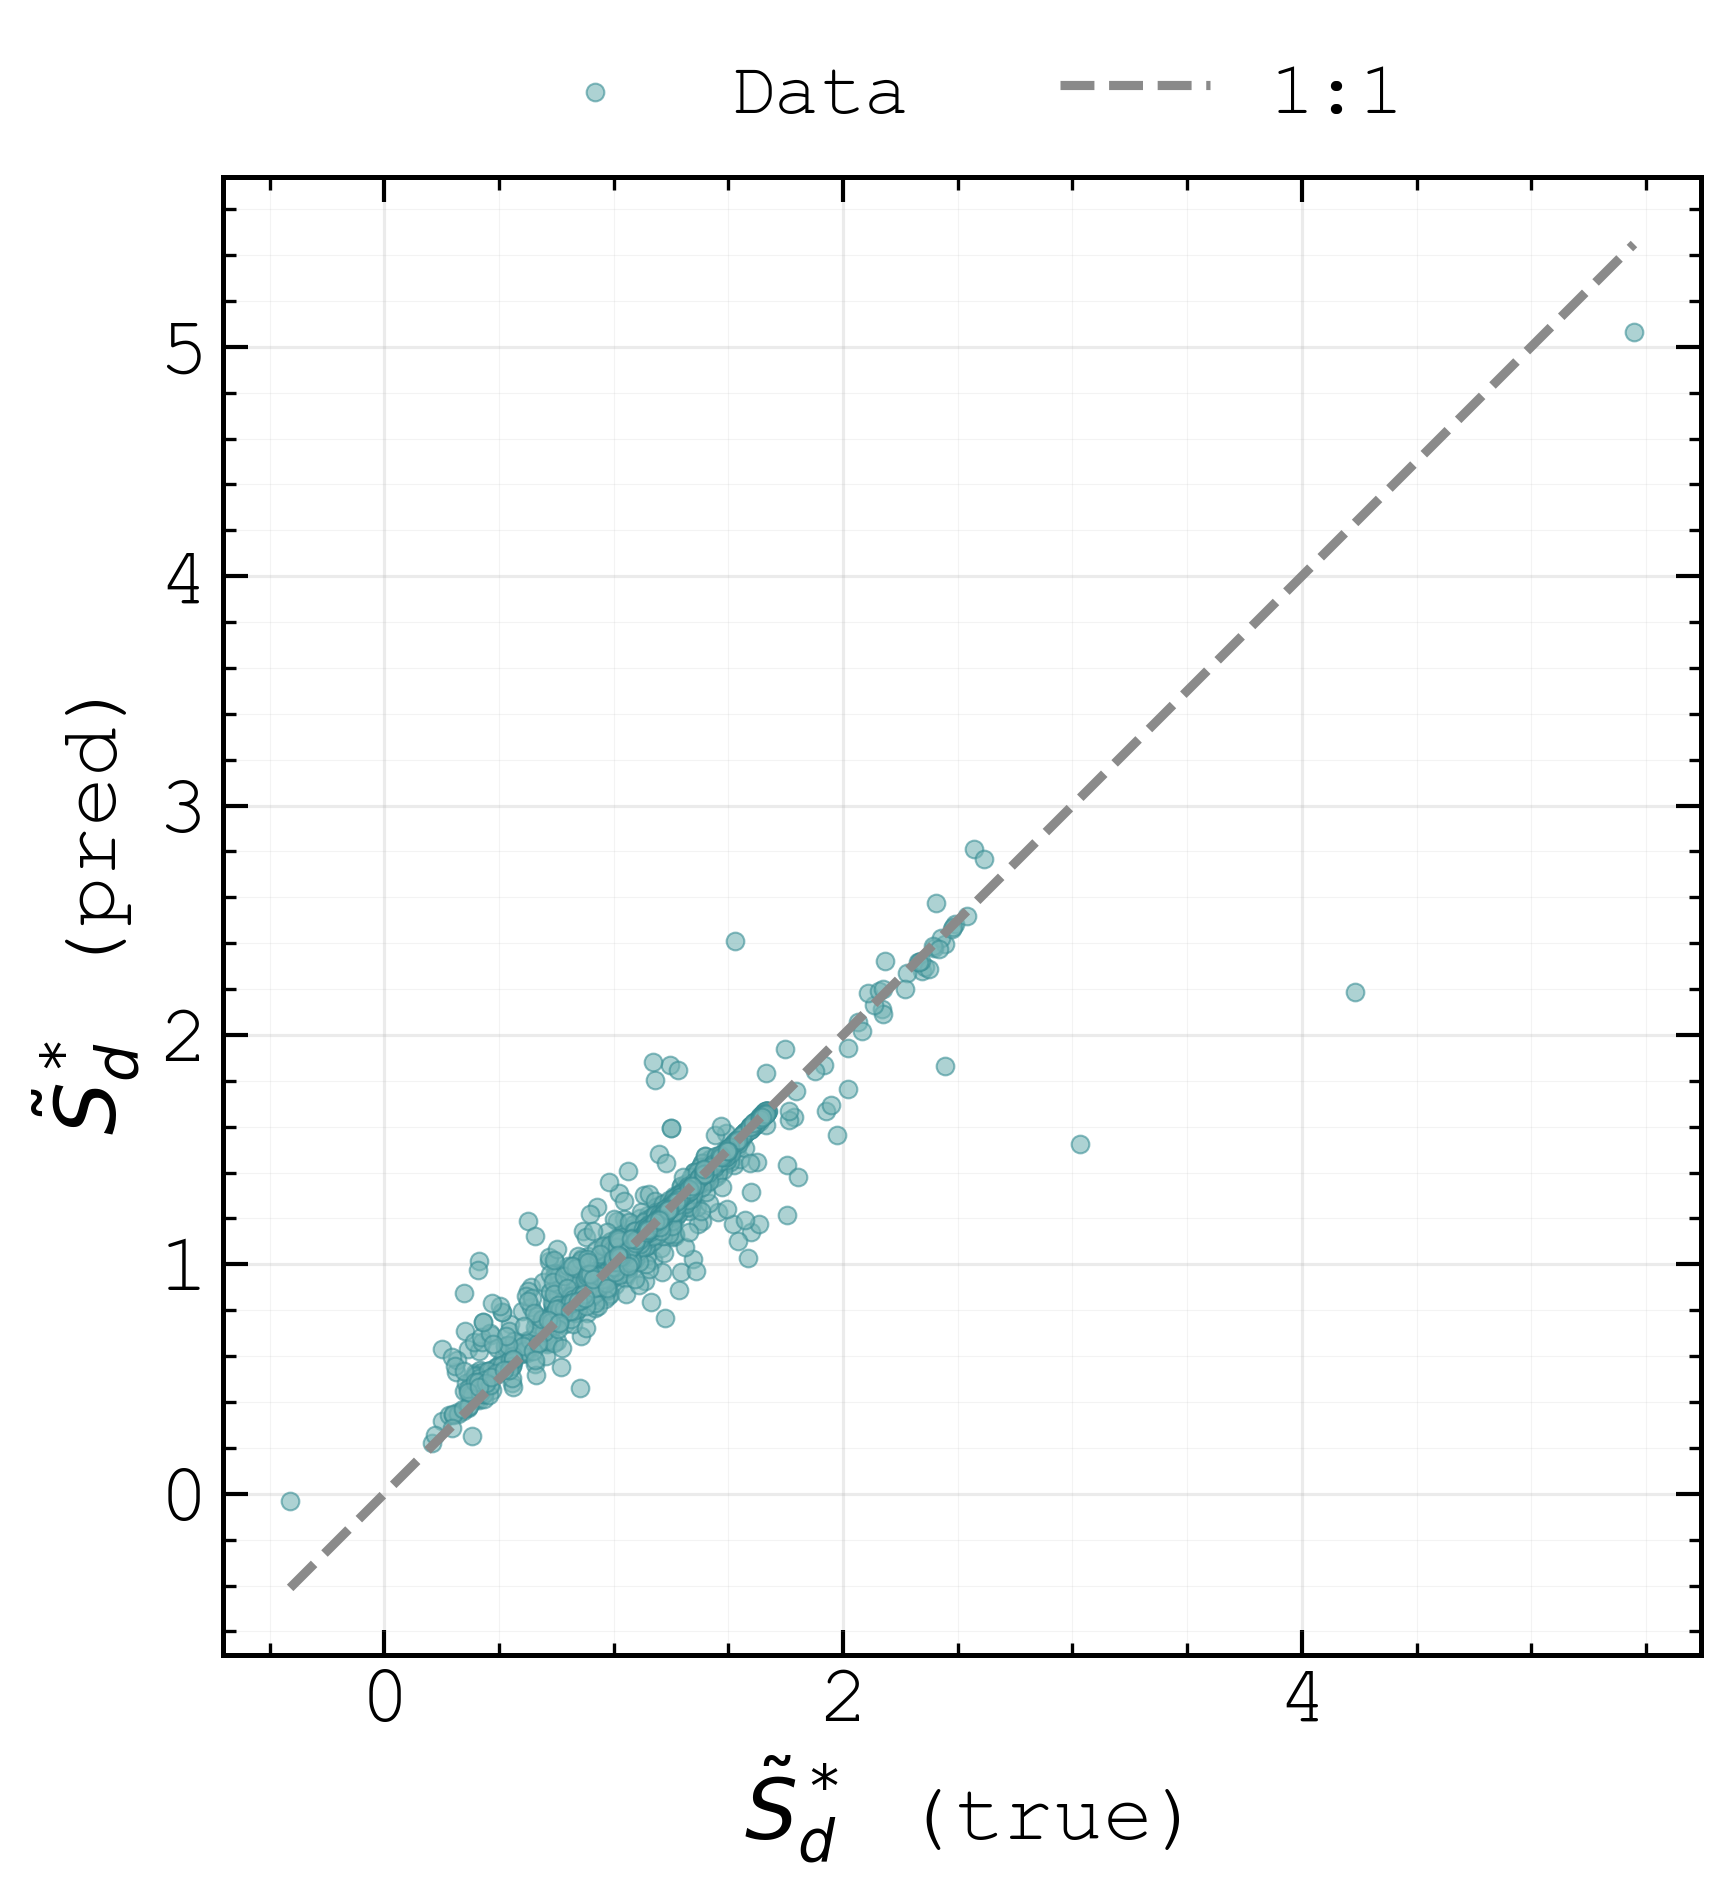


Global model accuracy: R2=0.9200 | RMSE=7.322704e-02

[INFO] Wrote global selection: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/report_figures/results/backward_selection/lat_100/t_198_to_202/h_100_t_198_199_200_201_202_iso_0.6/backward_selected_global.csv


In [4]:
X_all = dfc[model_features].to_numpy()
y_all = dfc[TARGET_VAR].to_numpy()

selected_global = run_backward_selection(
    X=X_all,
    y=y_all,
    feature_names=model_features,
    n_features_to_select=BACKWARD_N_FEATURES_GLOBAL,
    random_state=RANDOM_STATE,
    scoring=SFS_SCORING,
    cv_splits=SFS_CV_SPLITS,
)

print("\nGlobal backward selection:")
print(selected_global)

r2_global = np.nan
rmse_global = np.nan
if selected_global:
    X_sel = dfc[selected_global].to_numpy()
    r2_global, rmse_global, y_true_global, y_pred_global = evaluate_selected_model(
        X=X_sel,
        y=y_all,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
    )
    plot_pred_vs_true(
        y_true_global,
        y_pred_global,
        title="Global model",
        save_stem="pred_vs_true_global",
    )

summary_global = pd.DataFrame({
    "rank": list(range(1, len(selected_global) + 1)),
    "feature": selected_global,
})
summary_global["r2"] = r2_global
summary_global["rmse"] = rmse_global
summary_global_csv = SAVE_DIR / "backward_selected_global.csv"
summary_global.to_csv(summary_global_csv, index=False)
print(f"\nGlobal model accuracy: R2={r2_global:.4f} | RMSE={rmse_global:.6e}")
print(f"\n[INFO] Wrote global selection: {summary_global_csv}")


### Curvature binnning (predefined thresholds)


Curvature bins: (-0.1, 0.1) -> clusters 0..2


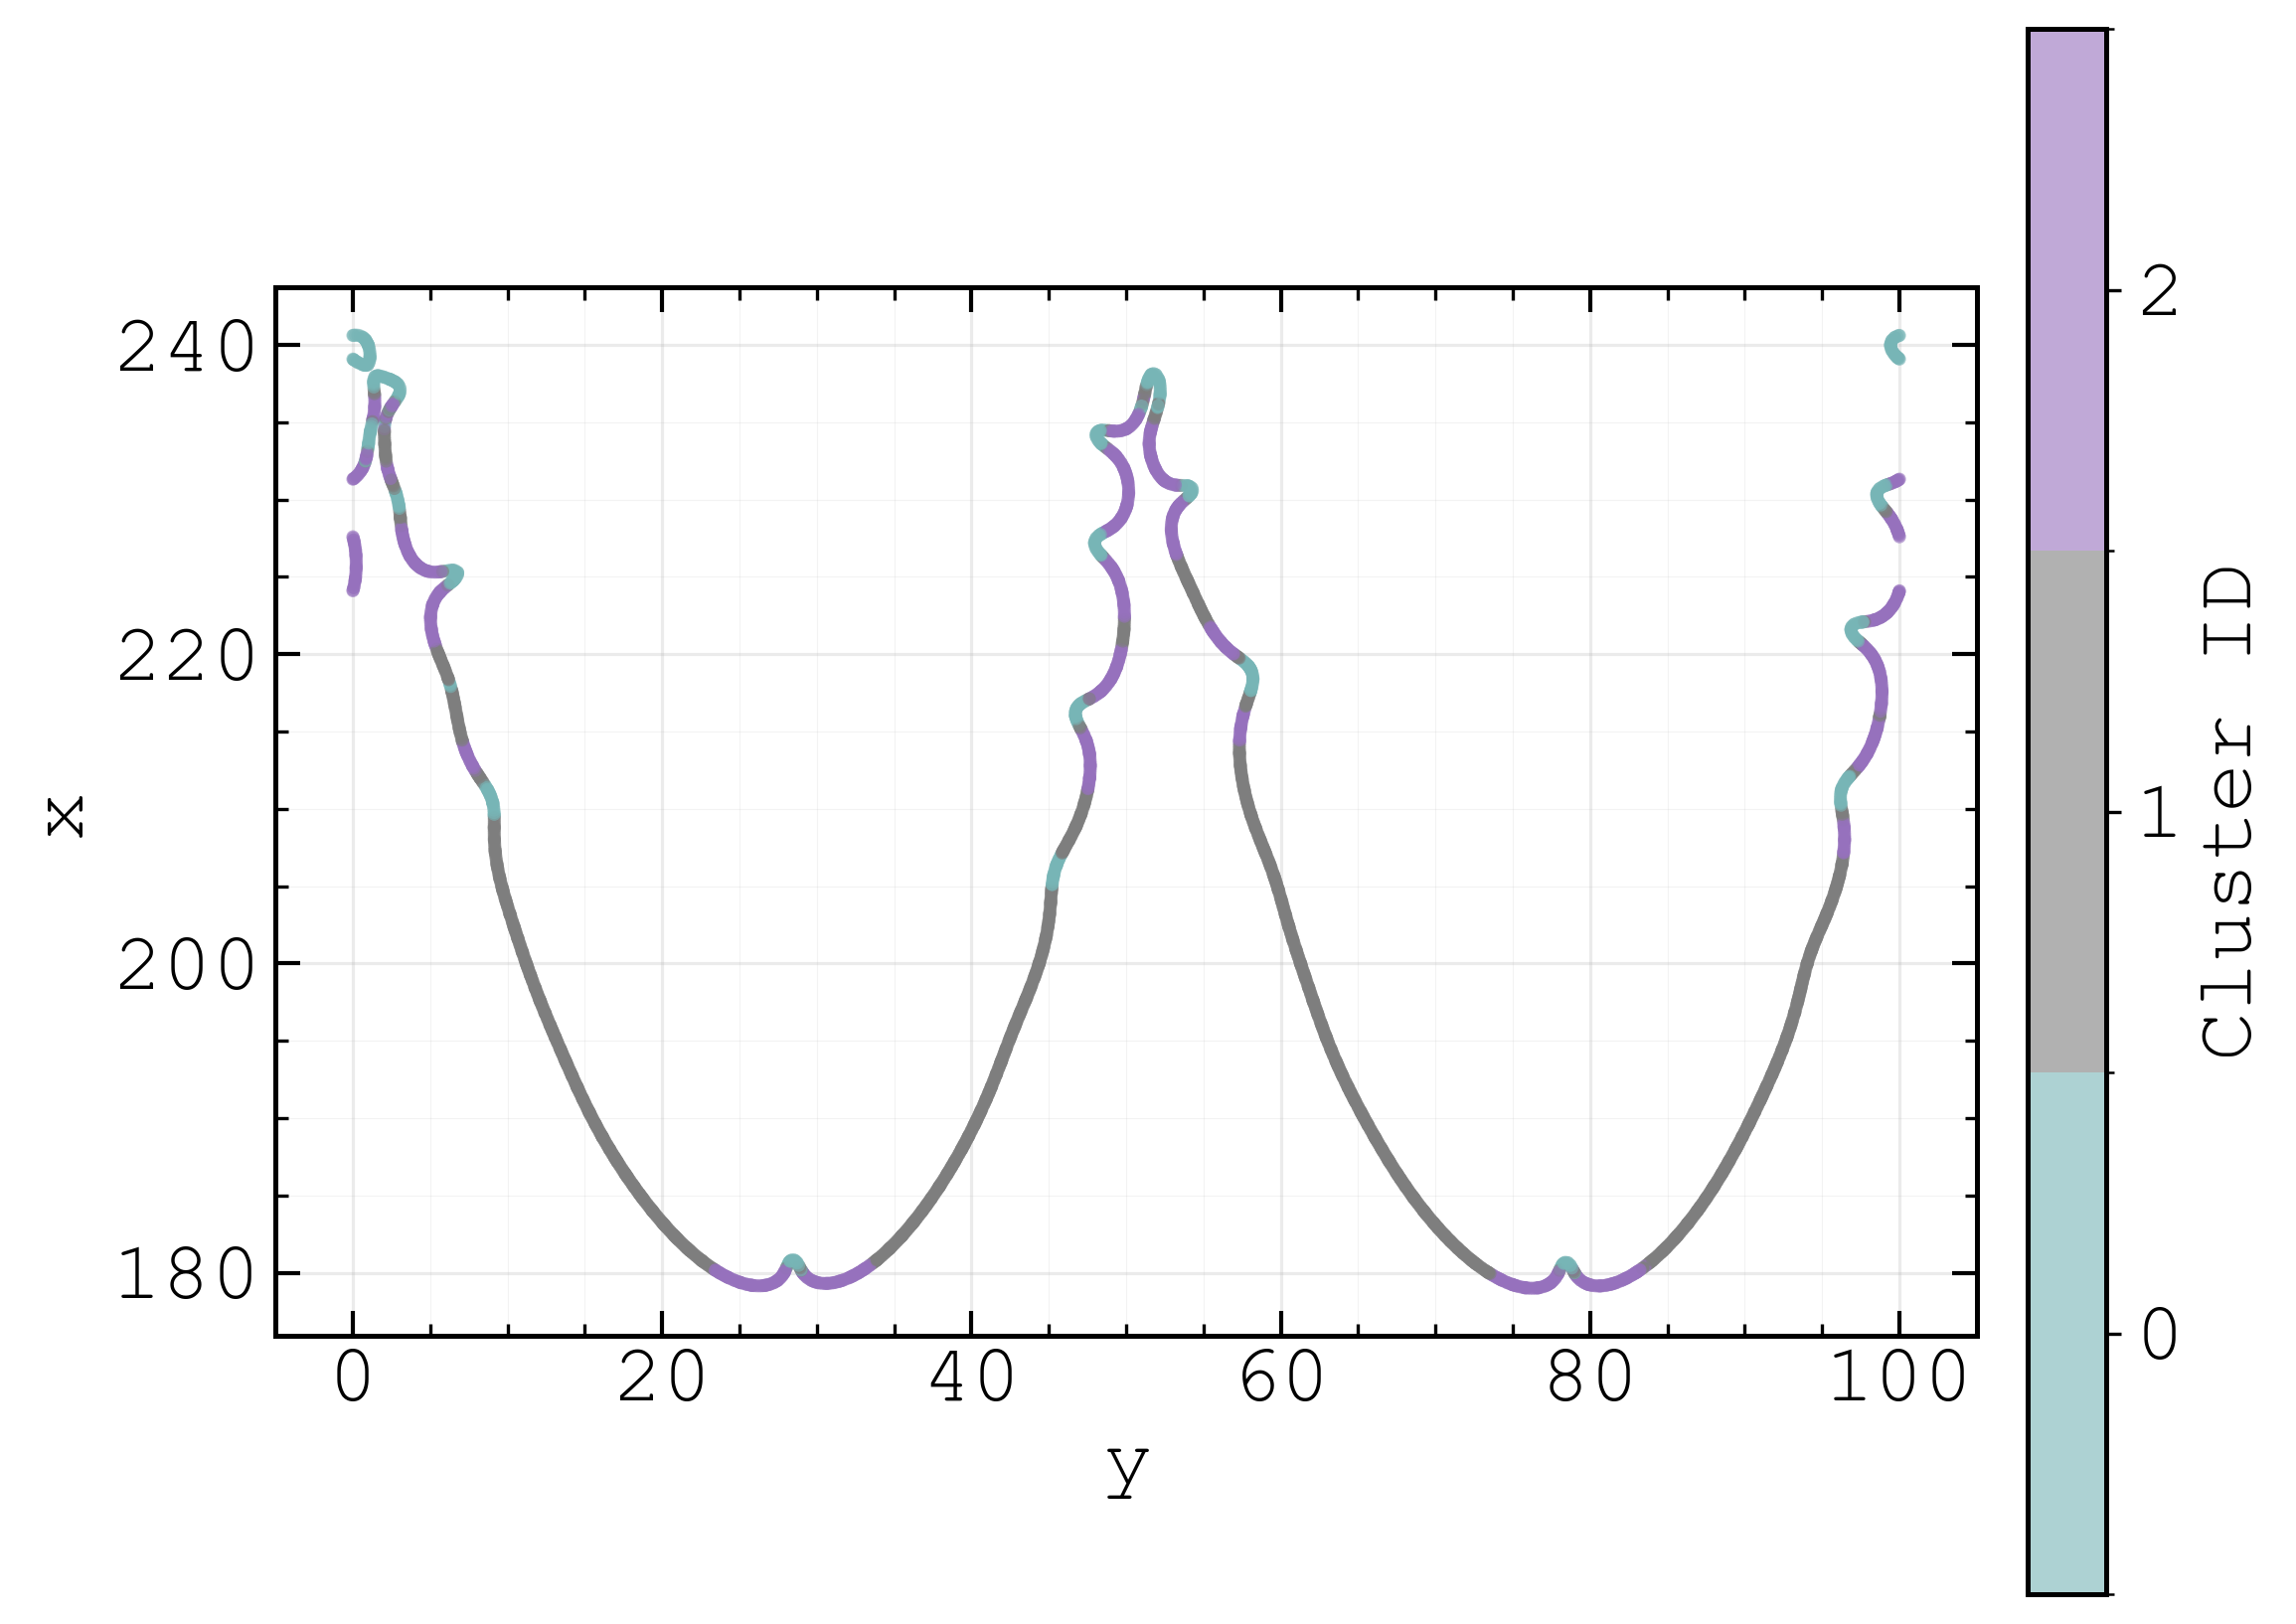

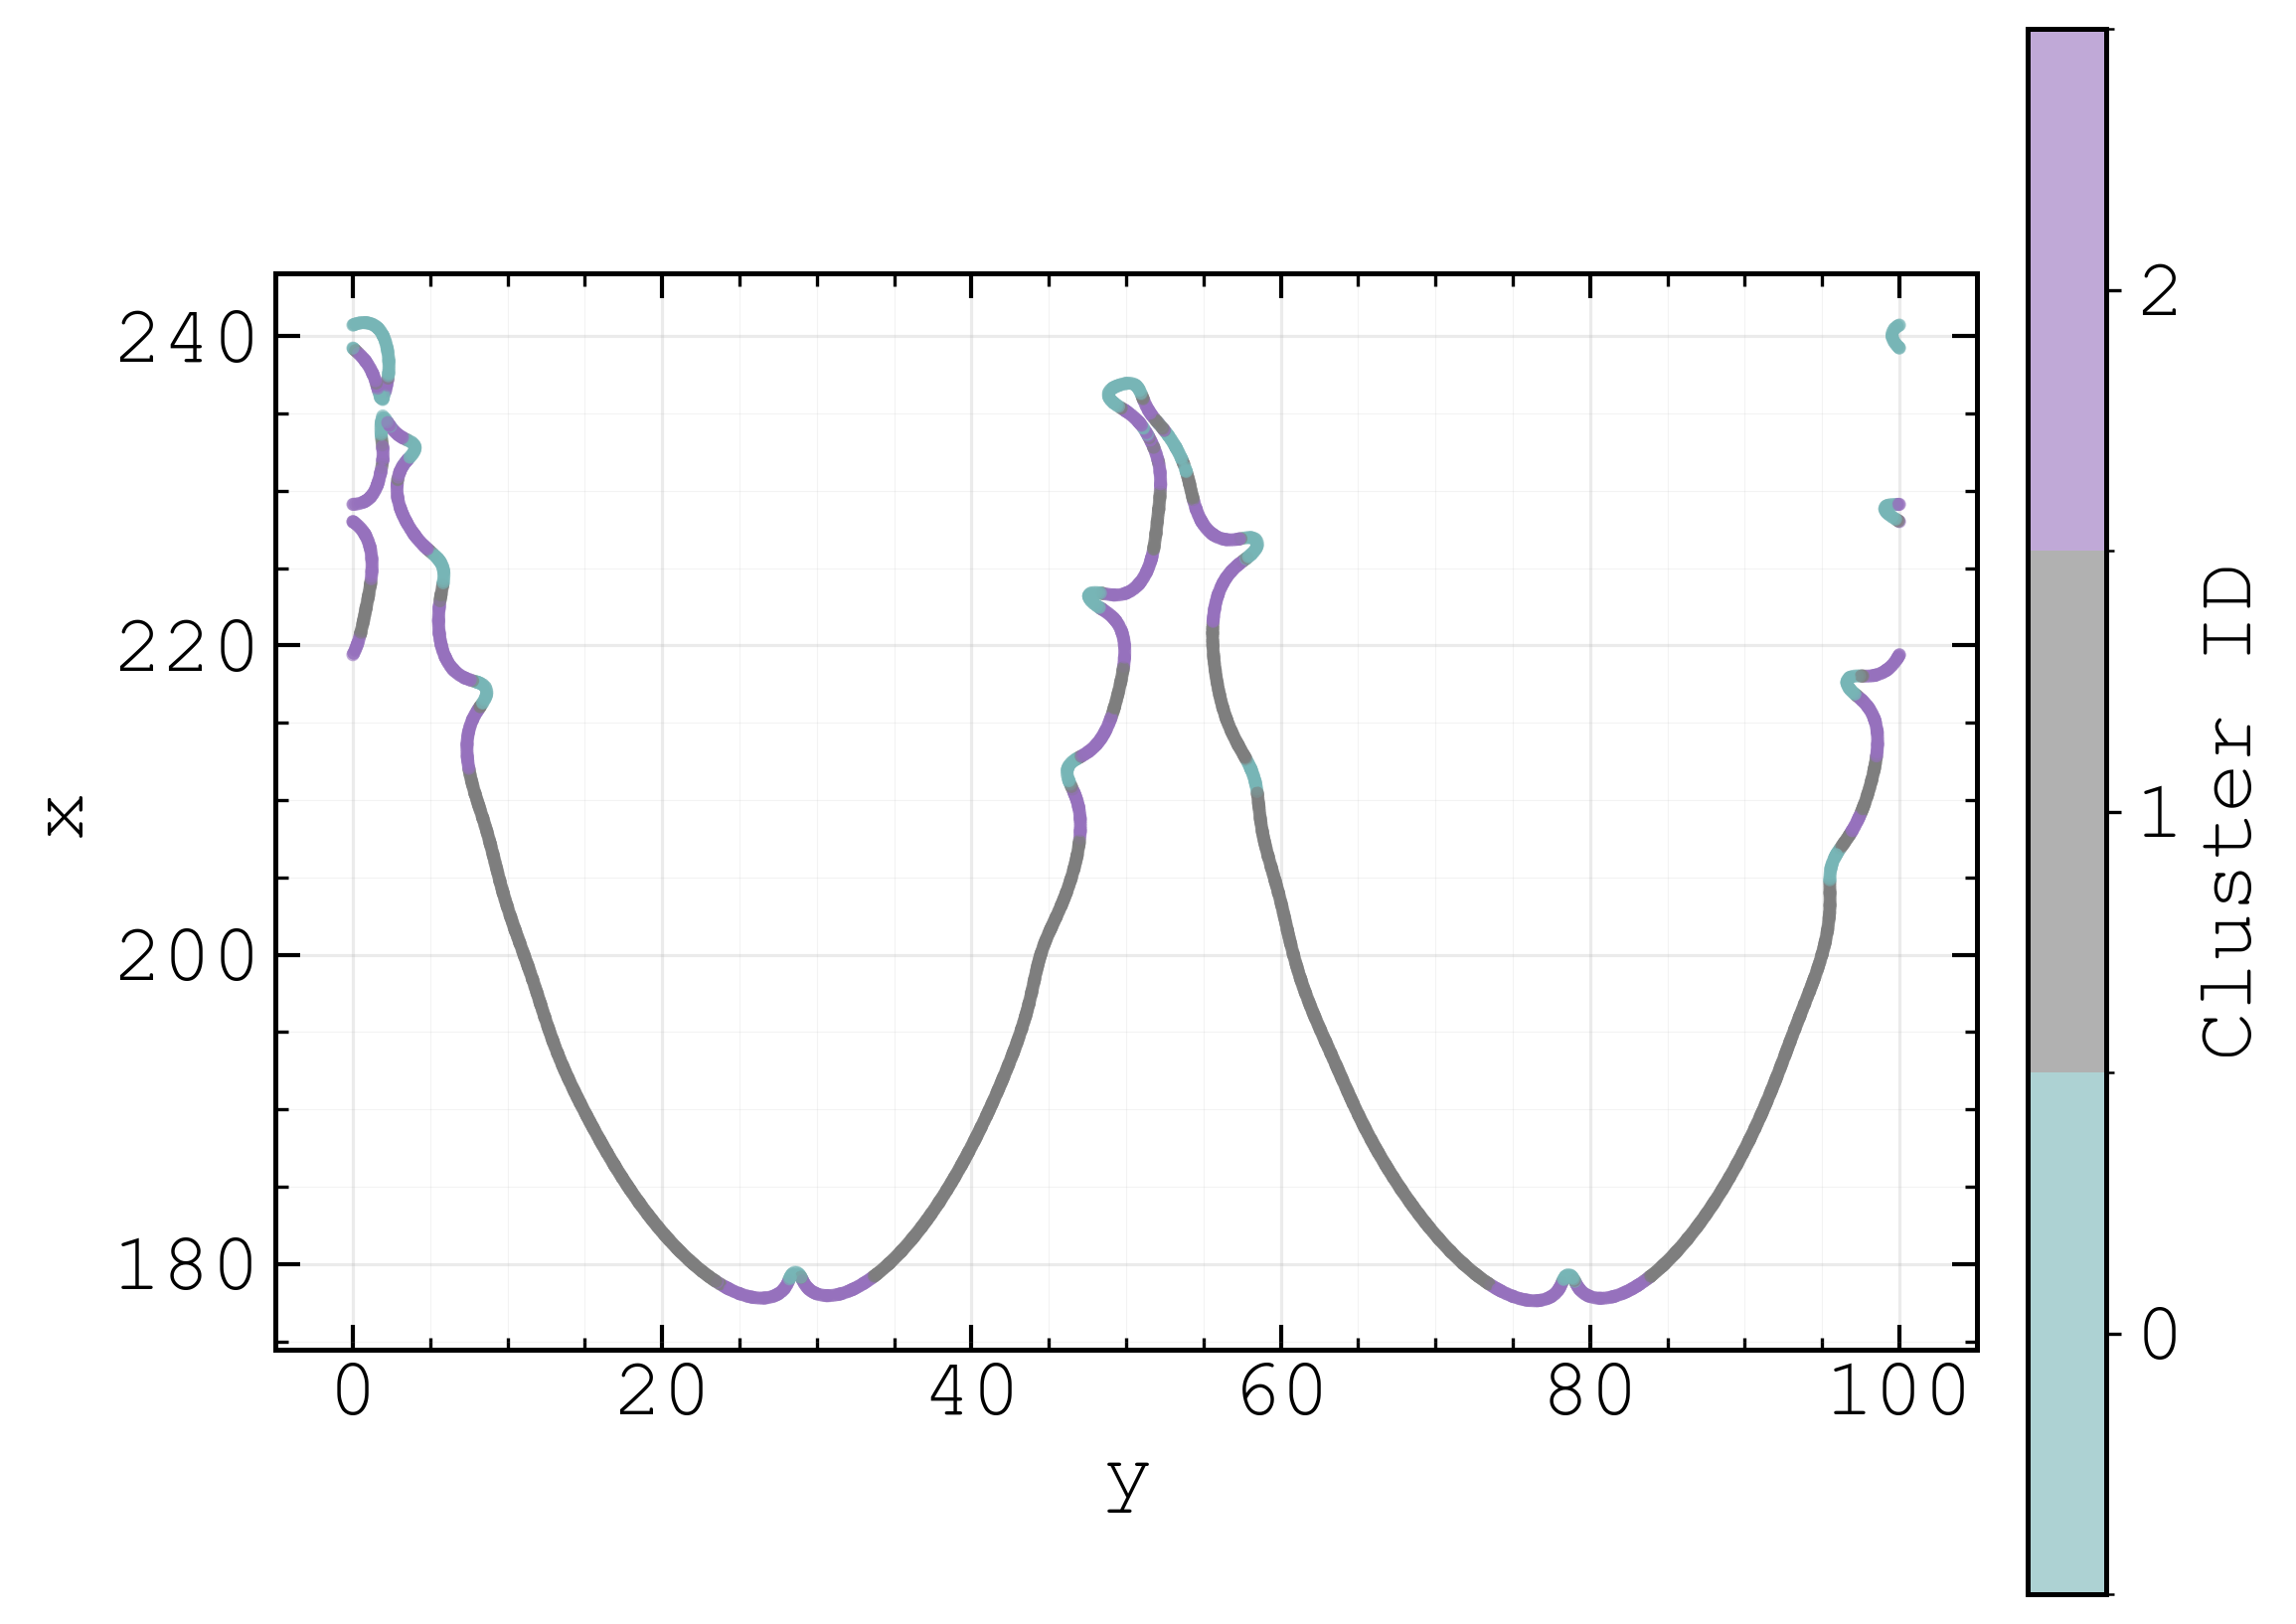

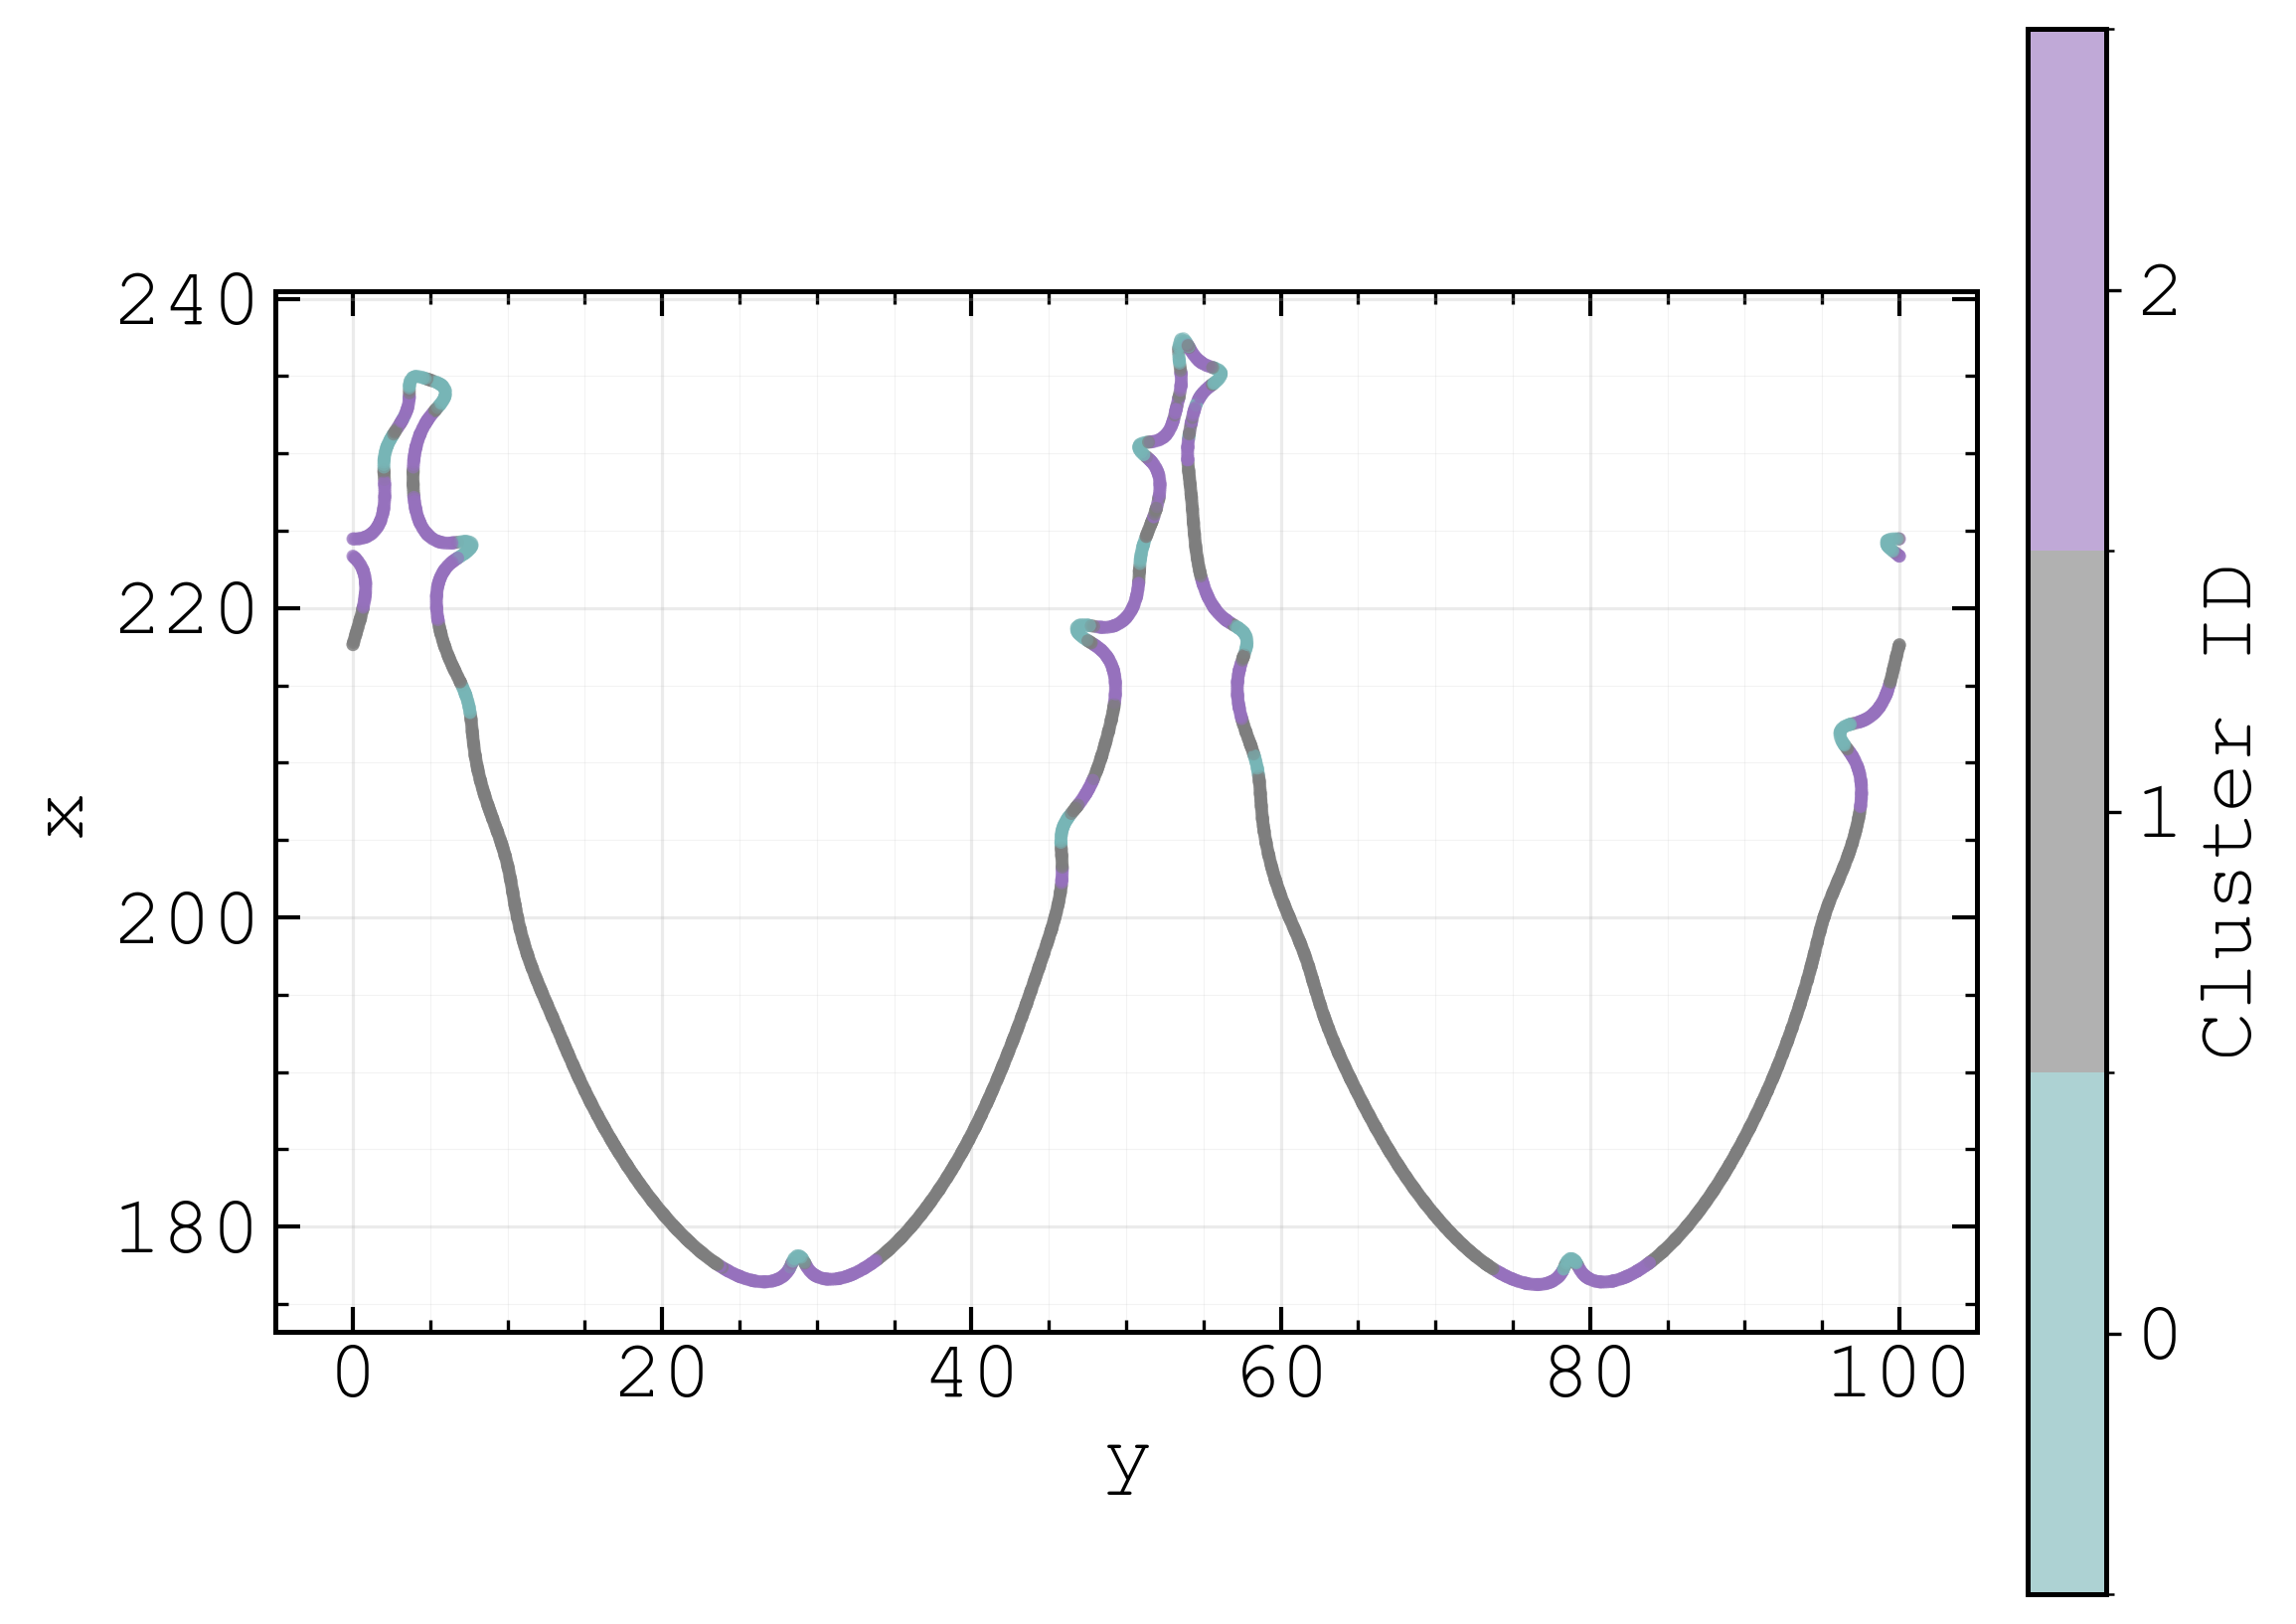

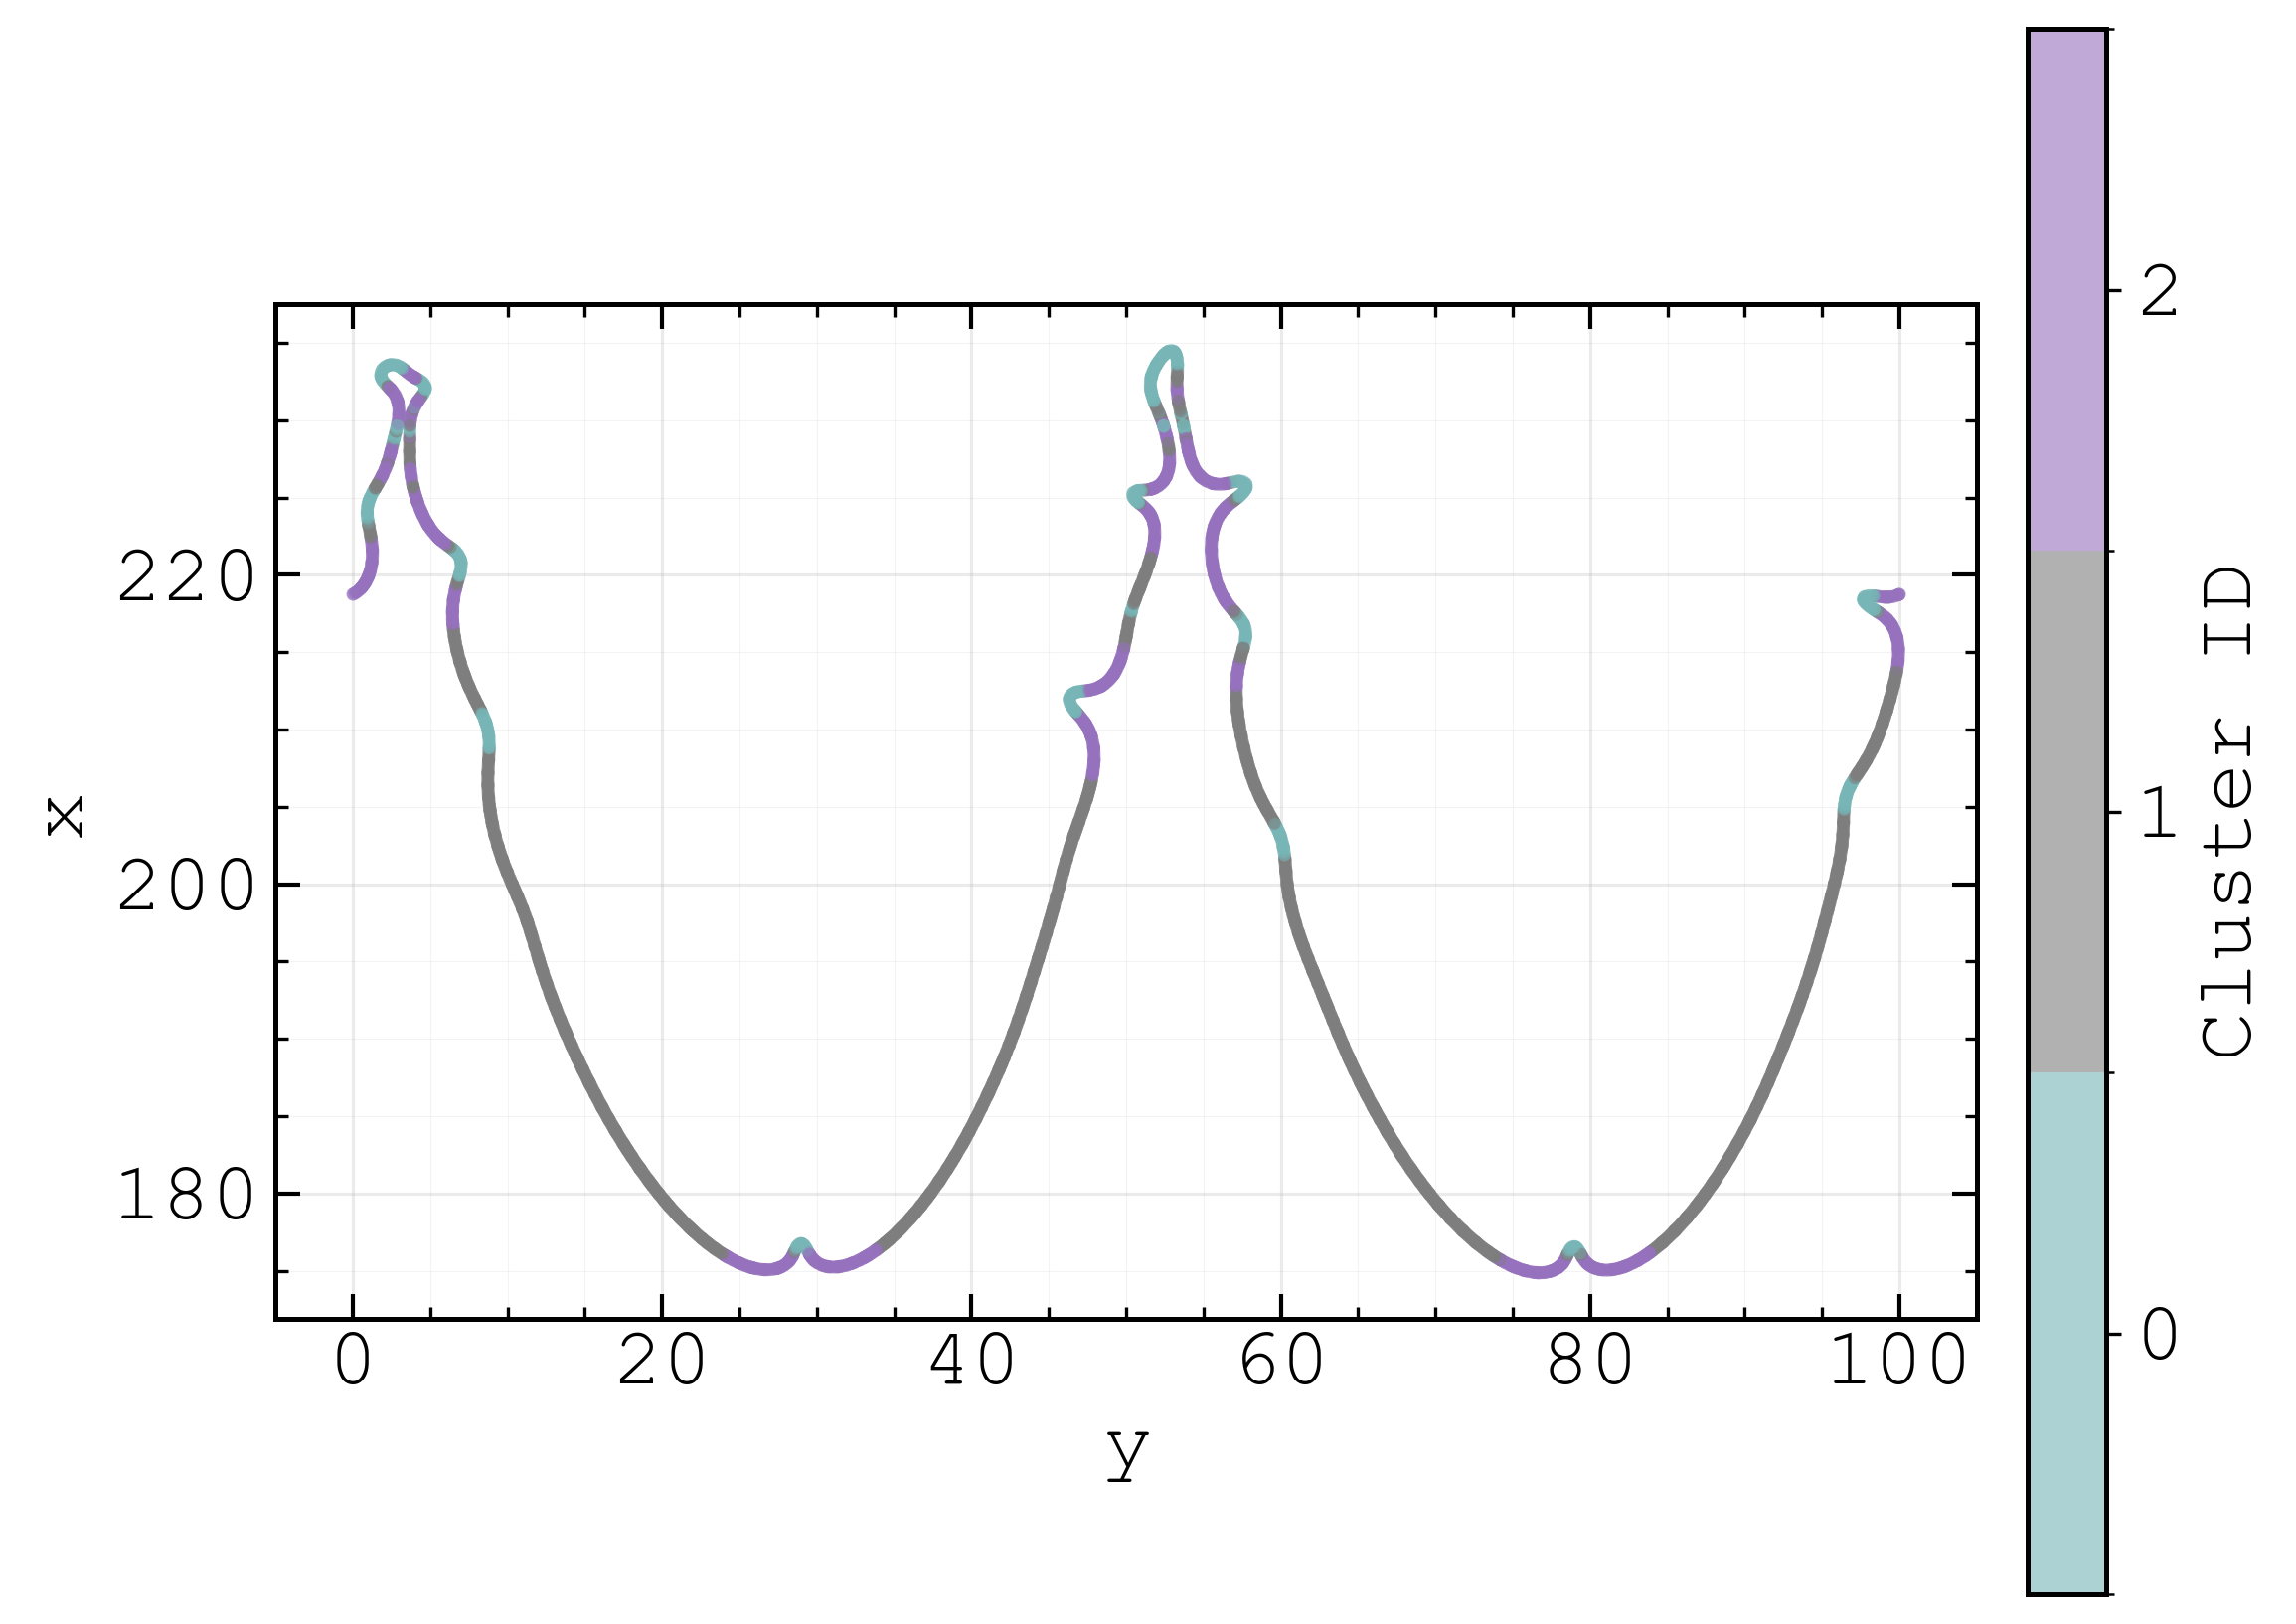

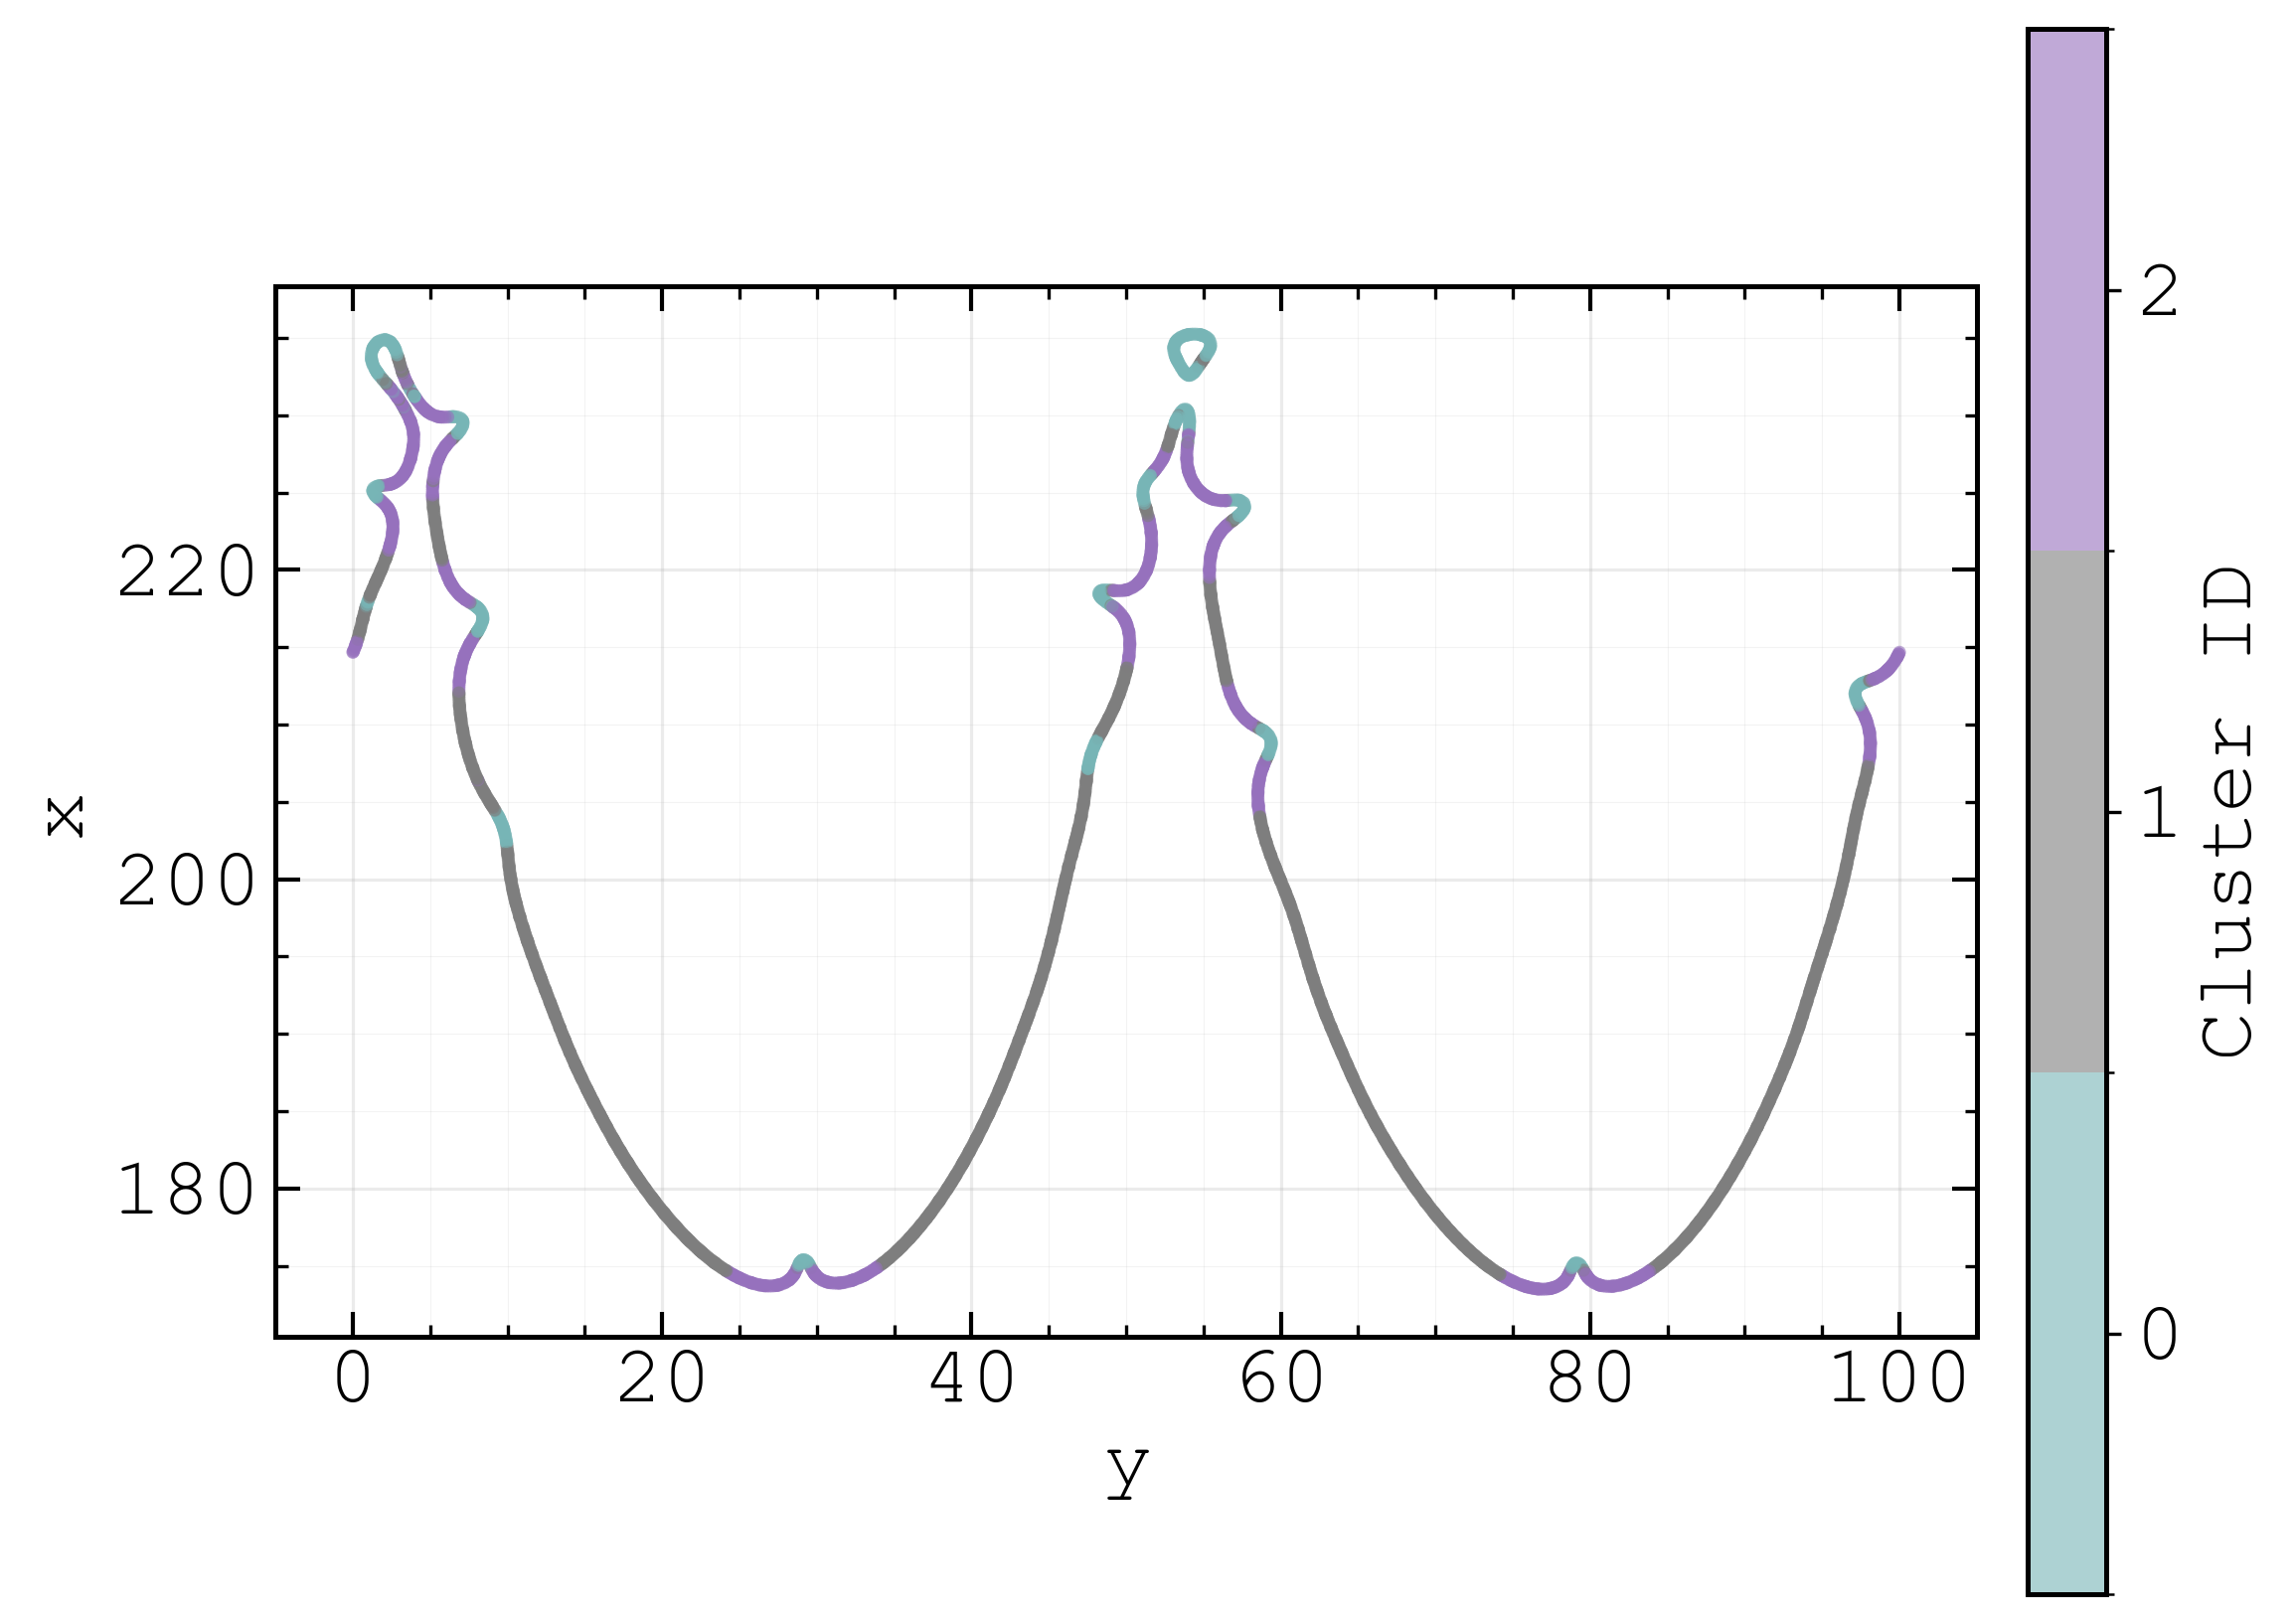

In [5]:
curv_col = CURVATURE_COLUMN
if curv_col not in dfc.columns:
    raise ValueError(f"CURVATURE_COLUMN '{curv_col}' not found in dataframe")

if len(CURVATURE_BOUNDS) != 2:
    raise ValueError("CURVATURE_BOUNDS must contain exactly two values")
low, high = CURVATURE_BOUNDS
if low >= high:
    raise ValueError("CURVATURE_BOUNDS must be strictly increasing (low < high)")

dfc["cluster"] = np.digitize(
    dfc[curv_col].to_numpy(),
    bins=[low, high],
    right=True,
)

print(f"\nCurvature bins: {CURVATURE_BOUNDS} -> clusters 0..{N_CLUSTERS - 1}")
for ts in TIME_STEPS:
    sub = dfc[dfc["timestep"] == ts].copy()
    if len(sub) == 0:
        continue
    plot_isocontour_scatter(
        sub,
        save_stem=f"isocontour_xy_iso{ISOLEVEL}_ts{ts}",
    )


### Per-cluster backward selection


--- Cluster 0 (CURVATURE BIN) | n=2096 ---


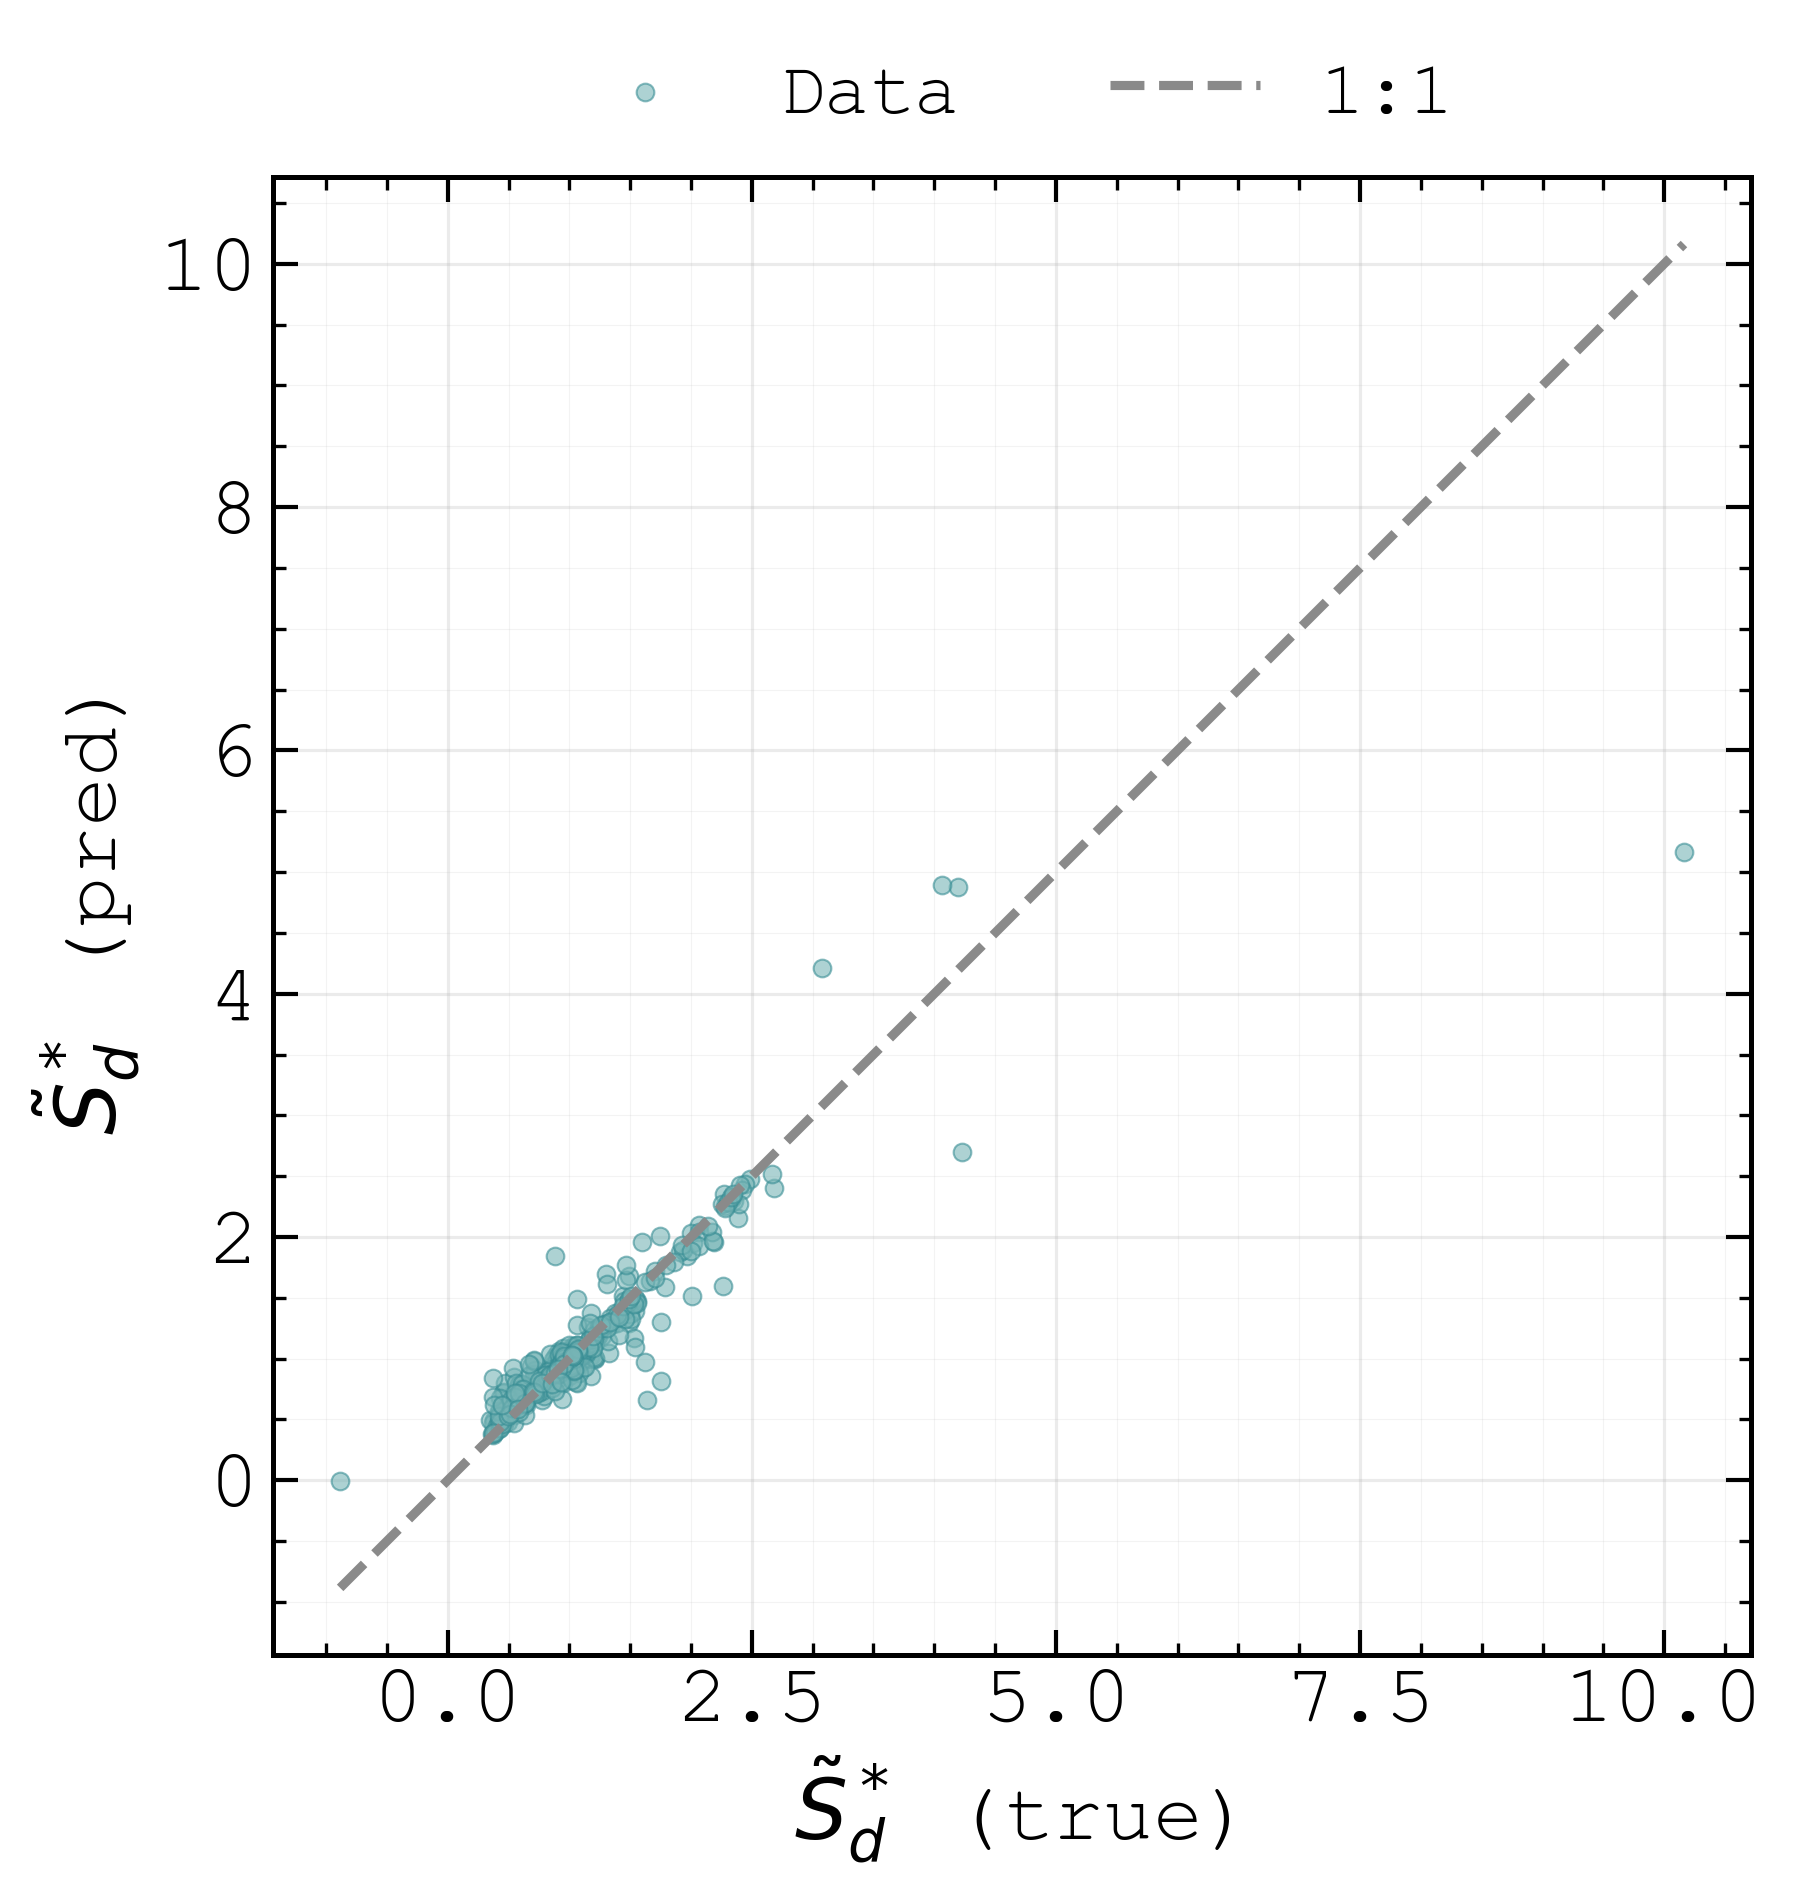

Accuracy: R2=0.8112 | RMSE=2.762704e-01
Selected features (backward order):
  01. dTdx
  02. du_ndx
  03. du_tdy
  04. vorticity

--- Cluster 1 (CURVATURE BIN) | n=9670 ---


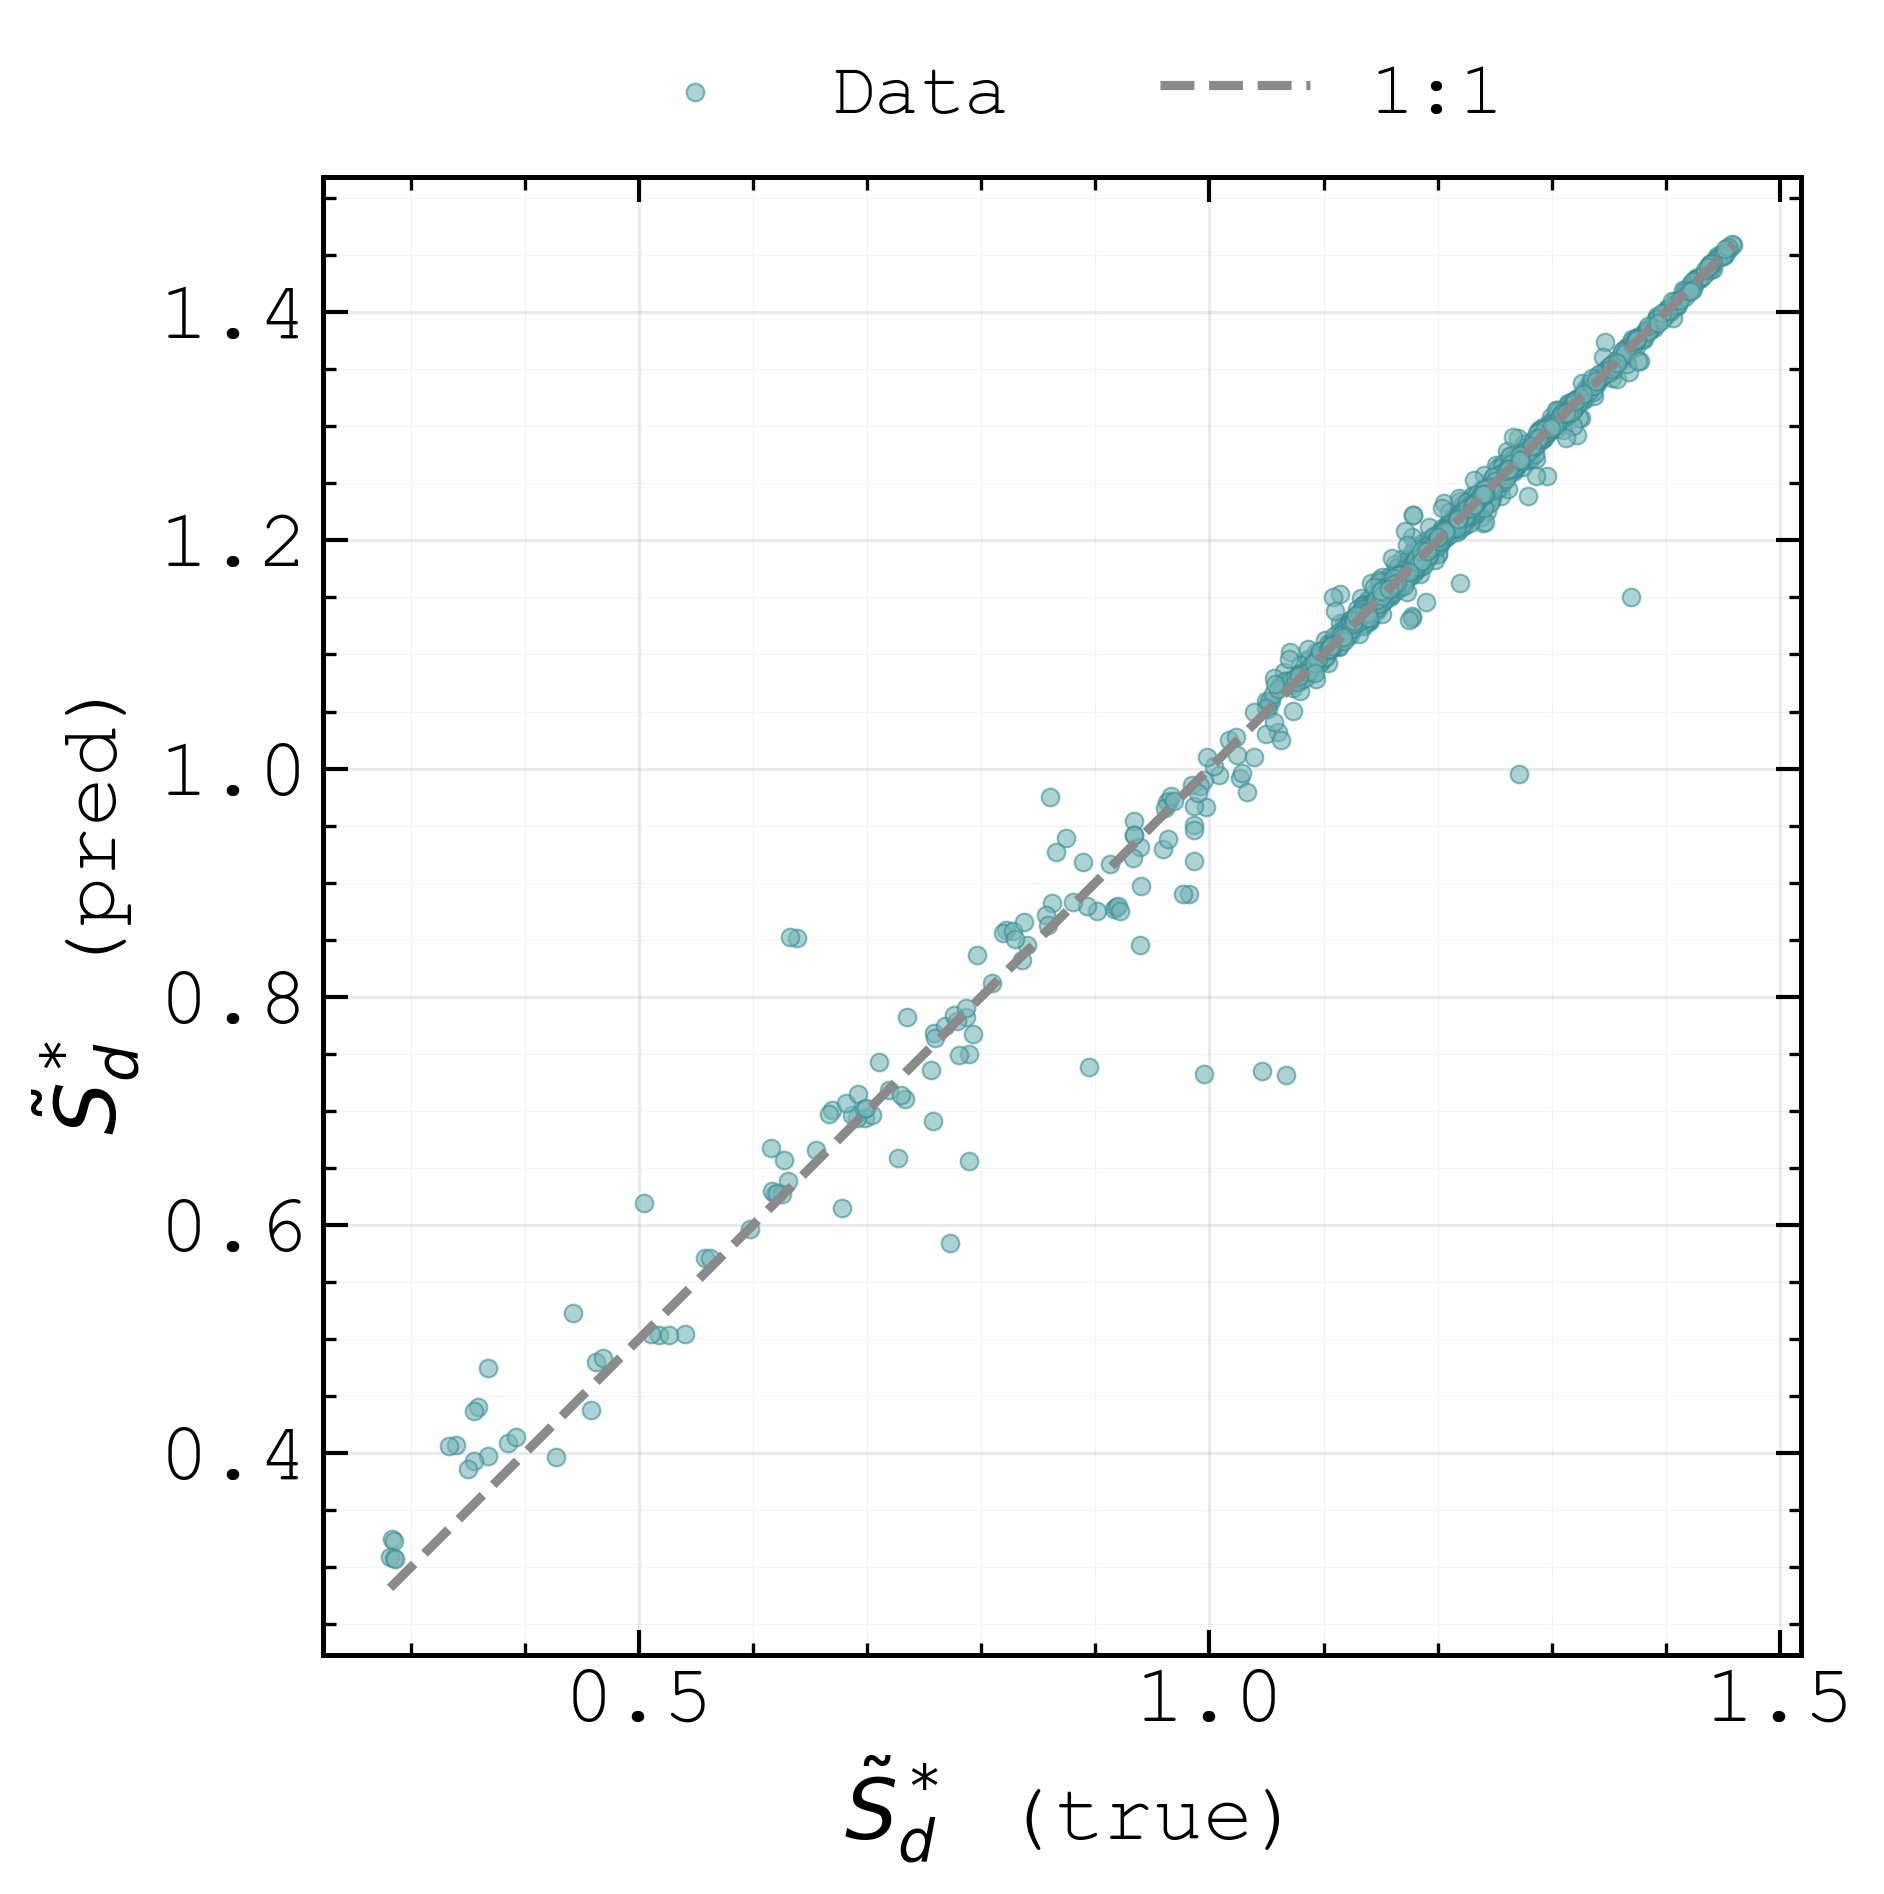

Accuracy: R2=0.9819 | RMSE=1.847403e-02
Selected features (backward order):
  01. du_ndy
  02. u_n
  03. u_t
  04. vorticity

--- Cluster 2 (CURVATURE BIN) | n=4741 ---


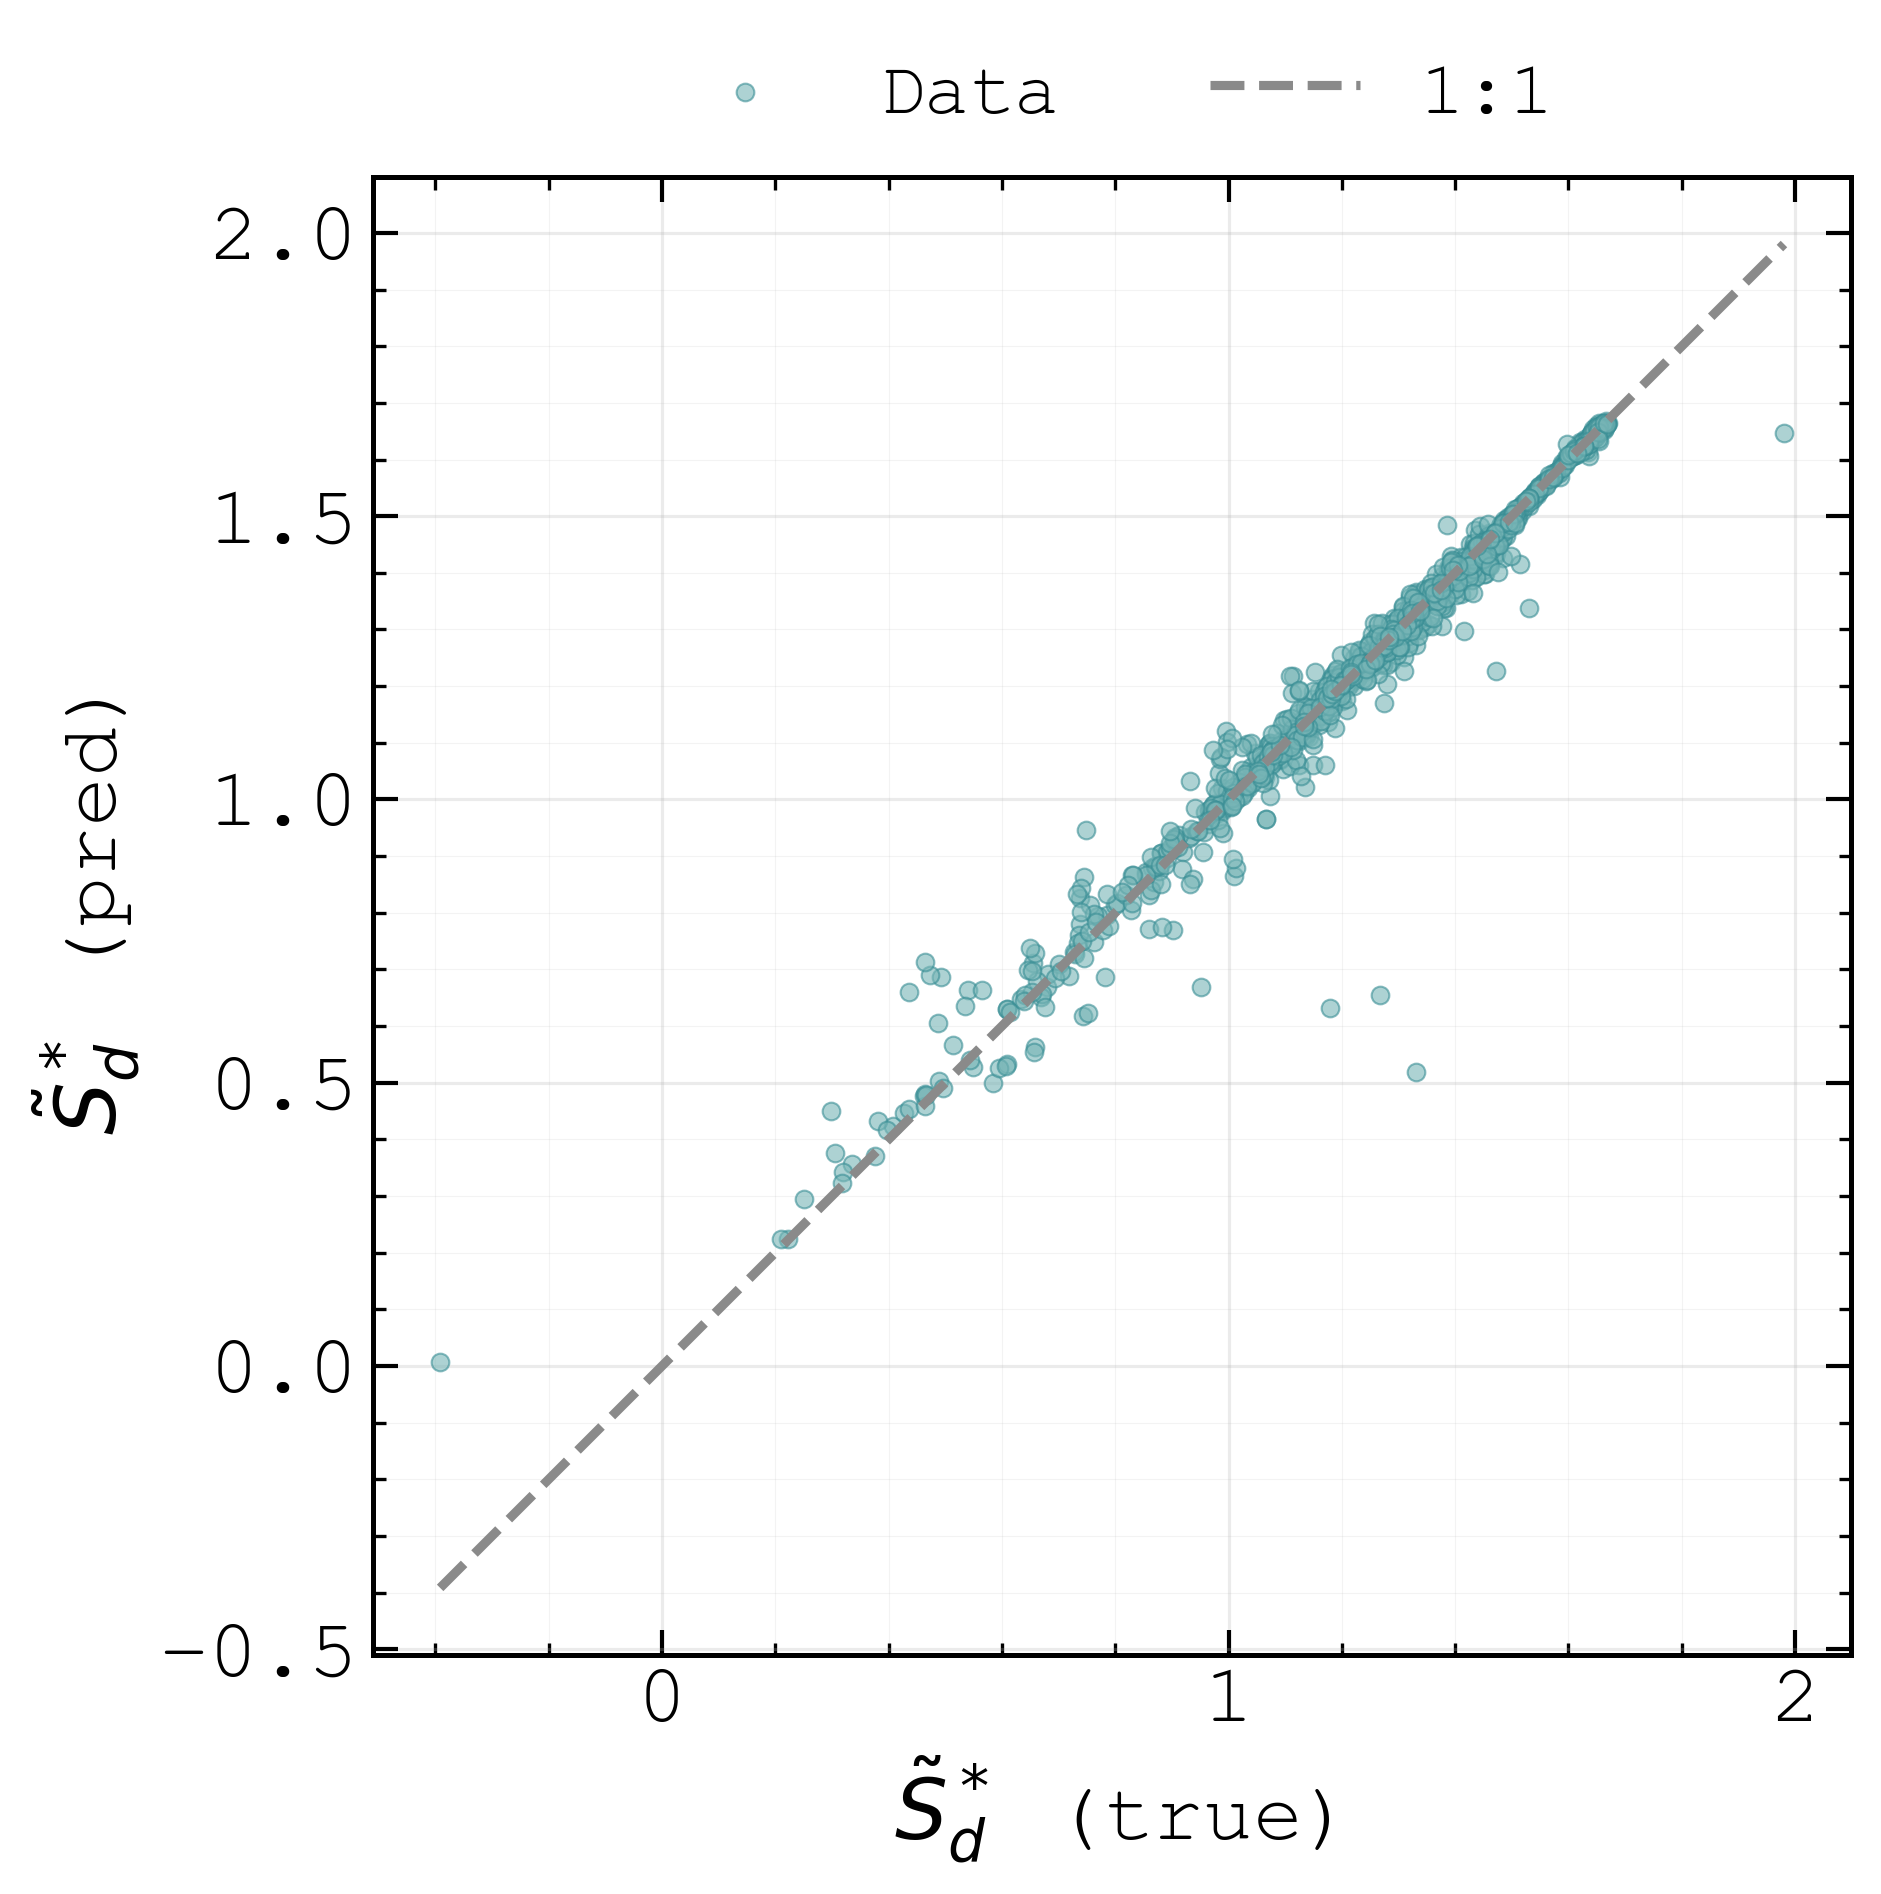

Accuracy: R2=0.9674 | RMSE=5.001778e-02
Selected features (backward order):
  01. dTdx
  02. dTdy
  03. du_ndx
  04. vorticity

Summary (backward selected features per cluster):
 cluster  rank   feature  n_cluster
       0     1      dTdx       2096
       0     2    du_ndx       2096
       0     3    du_tdy       2096
       0     4 vorticity       2096
       1     1    du_ndy       9670
       1     2       u_n       9670
       1     3       u_t       9670
       1     4 vorticity       9670
       2     1      dTdx       4741
       2     2      dTdy       4741
       2     3    du_ndx       4741
       2     4 vorticity       4741

[INFO] Wrote per-cluster selection: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/report_figures/results/backward_selection/lat_100/t_198_to_202/h_100_t_198_199_200_201_202_iso_0.6/backward_selected_per_cluster.csv

Per-cluster model accuracy:
 cluster  n_cluster  n_features       r2     rmse
       0       2096           4 0.811231 

In [6]:
selected_rows: List[dict] = []
cluster_metrics_rows: List[dict] = []

for cl in range(N_CLUSTERS):
    sub = dfc[dfc["cluster"] == cl].copy()
    n_cl = len(sub)
    print(f"\n--- Cluster {cl} (CURVATURE BIN) | n={n_cl} ---")

    if n_cl < MIN_CLUSTER_SAMPLES:
        print(f"Skipping (n < MIN_CLUSTER_SAMPLES={MIN_CLUSTER_SAMPLES})")
        continue

    X = sub[model_features].to_numpy()
    y = sub[TARGET_VAR].to_numpy()

    selected = run_backward_selection(
        X=X,
        y=y,
        feature_names=model_features,
        n_features_to_select=BACKWARD_N_FEATURES_CLUSTER,
        random_state=RANDOM_STATE,
        scoring=SFS_SCORING,
        cv_splits=SFS_CV_SPLITS,
    )

    r2_cl = np.nan
    rmse_cl = np.nan
    if selected:
        X_sel = sub[selected].to_numpy()
        r2_cl, rmse_cl, y_true_cl, y_pred_cl = evaluate_selected_model(
            X=X_sel,
            y=y,
            test_size=TEST_SIZE,
            random_state=RANDOM_STATE,
        )
        plot_pred_vs_true(
            y_true_cl,
            y_pred_cl,
            title=f"Cluster {cl}",
            save_stem=f"pred_vs_true_cluster_{cl}",
        )

    cluster_metrics_rows.append({
        "cluster": cl,
        "n_cluster": int(n_cl),
        "n_features": int(len(selected)),
        "r2": r2_cl,
        "rmse": rmse_cl,
    })

    print(f"Accuracy: R2={r2_cl:.4f} | RMSE={rmse_cl:.6e}")
    print("Selected features (backward order):")
    for i, f in enumerate(selected, 1):
        print(f"  {i:02d}. {f}")
        selected_rows.append({
            "cluster": cl,
            "rank": i,
            "feature": f,
            "n_cluster": int(n_cl),
        })

if selected_rows:
    summary_df = pd.DataFrame(selected_rows)
    summary_csv = SAVE_DIR / "backward_selected_per_cluster.csv"
    summary_df.to_csv(summary_csv, index=False)

    print("\nSummary (backward selected features per cluster):")
    print(summary_df.to_string(index=False))
    print(f"\n[INFO] Wrote per-cluster selection: {summary_csv}")
else:
    print("\nNo clusters met MIN_CLUSTER_SAMPLES; no per-cluster results to report.")

if cluster_metrics_rows:
    metrics_df = pd.DataFrame(cluster_metrics_rows)
    metrics_csv = SAVE_DIR / "backward_cluster_metrics.csv"
    metrics_df.to_csv(metrics_csv, index=False)
    print("\nPer-cluster model accuracy:")
    print(metrics_df.to_string(index=False))
    print(f"\n[INFO] Wrote per-cluster metrics: {metrics_csv}")

print(f"\nSaved outputs to: {SAVE_DIR}")
